In [60]:
# Install a pip package in the current Jupyter kernel
import sys
import os
sys.path.append('../')
sys.path.append('../wdtools')
sys.path.append('../WD_models')
sys.path.append('../corv/src')


### General
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors

import astropy
from astropy.coordinates import SkyCoord
from astropy.io import fits
import astropy.units as u
from astropy.table import Table, Column, MaskedColumn, join

from tqdm import tqdm
import pandas as pd
from scipy.optimize import curve_fit
import scipy.stats as stats

### Tools
import wdtools
import WD_models
import data_selector as ds
import WD_models
from bisect import bisect_left
import lmfit
import glob

from astroquery.sdss import SDSS
from astroquery.gaia import Gaia

import corv

#corv.sdss.make_catalogs()

2022-10-11 19:19:26.473378: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-10-11 19:19:26.473473: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Please install galpy if you want to use the gaia module. otherwise, ignore this.
using local paths
star and exposure catalogs not found! check paths and run make_catalogs() if you want to use sdss functionality. otherwise ignore.


In [4]:
c = 2.998e10
k = 1.38e-16
h = 6.626e-27
halpha = 6564.61
hbeta = 4862.68
hgamma = 4341.68
hdelta = 4102.89
speed_light = 299792458 #m/s
radius_sun = 6.957e8
mass_sun = 1.9884e30
newton_G = 6.674e-11
pc_to_m = 3.086775e16

In [21]:
catalog = Table.read('/home/arseneausm/Downloads/sed_radii.fits')
catalog['corv_rv'] = -9999 * np.ones(len(catalog))
catalog['corv_erv'] = -9999 * np.ones(len(catalog))

print(catalog.keys())  

['dist', 'solution_id', 'designation', 'source_id', 'random_index', 'ref_epoch', 'ra', 'ra_error', 'dec', 'dec_error', 'parallax', 'parallax_error', 'parallax_over_error', 'pmra', 'pmra_error', 'pmdec', 'pmdec_error', 'ra_dec_corr', 'ra_parallax_corr', 'ra_pmra_corr', 'ra_pmdec_corr', 'dec_parallax_corr', 'dec_pmra_corr', 'dec_pmdec_corr', 'parallax_pmra_corr', 'parallax_pmdec_corr', 'pmra_pmdec_corr', 'astrometric_n_obs_al', 'astrometric_n_obs_ac', 'astrometric_n_good_obs_al', 'astrometric_n_bad_obs_al', 'astrometric_gof_al', 'astrometric_chi2_al', 'astrometric_excess_noise', 'astrometric_excess_noise_sig', 'astrometric_params_solved', 'astrometric_primary_flag', 'astrometric_weight_al', 'astrometric_pseudo_colour', 'astrometric_pseudo_colour_error', 'mean_varpi_factor_al', 'astrometric_matched_observations', 'visibility_periods_used', 'astrometric_sigma5d_max', 'frame_rotator_object_type', 'matched_observations', 'duplicated_source', 'phot_g_n_obs', 'phot_g_mean_flux', 'phot_g_mean_f

In [4]:
for j in tqdm( range(len(catalog[:200]))):
    p,m,f = np.array(catalog['col_p_m_f'][j].split('-')).astype(float)
    
    try:
        xid = SDSS.query_specobj(plate = p, mjd = m, fiberID = f)
    except ValueError:
        print('unknown error')
        
    if xid == None:
        print('object not found in SDSS... skipping...')
        continue
    try:
        sp = SDSS.get_spectra(matches=xid)
    except:
        print('http error')
        continue
    for i in range(len(sp[0:1])):
        wl = np.array(10**sp[i][1].data['loglam'])
        fl = np.array(sp[i][1].data['flux'])
        ivar = np.array(sp[i][1].data['ivar'])
        
        corvmodel = corv.models.make_koester_model(names = ['a','b','g','d'])
        param_res, rv_res, rv_init = corv.fit.fit_corv(wl, fl, ivar, corvmodel, teff = catalog['teff'][j])
        print(catalog['vr'][j])
        
    catalog['corv_rv'][j] = (rv_res.params['RV'].value)
    catalog['corv_erv'][j] = (rv_res.params['RV'].stderr)

  0%|                                                                                   | 0/200 [00:00<?, ?it/s]/home/arseneausm/anaconda3/lib/python3.8/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),
/home/arseneausm/anaconda3/lib/python3.8/site-packages/astropy/table/table.py:3474: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


starting...


  0%|▎                                                                       | 1/200 [02:55<9:42:24, 175.60s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [22.39455753]
final params:
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 50000
    # data points      = 629
    # variables        = 1
    chi-square         = 1278.8485
    reduced chi-square = 2.03638298
    Akaike info crit   = 448.328395
    Bayesian info crit = 452.772527
[[Variables]]
    teff:  30901 (fixed)
    logg:  9.342187 (fixed)
    RV:    39.8876195 +/- 17.1456222 (42.98%) (init = 49.92199)
    res:   1 (fixed)
rv init: 49.921990732091615
28.0
starting...


  1%|▋                                                                       | 2/200 [05:51<9:39:56, 175.74s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [28.67441783]
final params:
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 50000
    # data points      = 629
    # variables        = 1
    chi-square         = 2449.6868
    reduced chi-square = 3.90077511
    Akaike info crit   = 857.178455
    Bayesian info crit = 861.622586
[[Variables]]
    teff:  28778 (fixed)
    logg:  9.087077 (fixed)
    RV:    84.1597146 +/- 14.0646329 (16.71%) (init = 111.9315)
    res:   1 (fixed)
rv init: 111.93147753294633
83.0
starting...


  2%|█                                                                       | 3/200 [08:46<9:35:38, 175.32s/it]

final params:
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 50000
    # data points      = 629
    # variables        = 1
    chi-square         = 553.23254
    reduced chi-square = 0.88094354
    Akaike info crit   = -78.7339301
    Bayesian info crit = -74.2897989
[[Variables]]
    teff:  15324 (fixed)
    logg:  8.023121 (fixed)
    RV:   -58.2088673 +/- 16.4430778 (28.25%) (init = -58.21858)
    res:   1 (fixed)
rv init: -58.21857660691546
-20.0
starting...


  2%|█▍                                                                      | 4/200 [11:43<9:35:18, 176.12s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [23.21217944]
final params:
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 50000
    # data points      = 629
    # variables        = 1
    chi-square         = 1464.0931
    reduced chi-square = 2.33135850
    Akaike info crit   = 533.416975
    Bayesian info crit = 537.861106
[[Variables]]
    teff:  23616 (fixed)
    logg:  9.489995 (fixed)
    RV:   -14.8932375 +/- 12.1854943 (81.82%) (init = 2.982777)
    res:   1 (fixed)
rv init: 2.9827774932864446
12.0
starting...


  2%|█▊                                                                      | 5/200 [14:41<9:34:47, 176.86s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [33.38109868]
final params:
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 50000
    # data points      = 629
    # variables        = 1
    chi-square         = 1246.359
    reduced chi-square = 1.98464810
    Akaike info crit   = 432.141983
    Bayesian info crit = 436.586115
[[Variables]]
    teff:  39999 (fixed)
    logg:  9.141247 (fixed)
    RV:    12.5204795 +/- 25.6181365 (204.61%) (init = 129.8027)
    res:   1 (fixed)
rv init: 129.8026658613059
0.0
starting...


  3%|██▏                                                                     | 6/200 [17:33<9:26:10, 175.11s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [22.15599339]
final params:
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 50000
    # data points      = 629
    # variables        = 1
    chi-square         = 613.68616
    reduced chi-square = 0.97720726
    Akaike info crit   = -13.5033428
    Bayesian info crit = -9.05921154
[[Variables]]
    teff:  16041 (fixed)
    logg:  8.515531 (fixed)
    RV:    44.4383435 +/- 26.8636571 (60.45%) (init = 63.72015)
    res:   1 (fixed)
rv init: 63.72014932789181
82.0
starting...


  4%|██▎                                                                | 7/200 [4:28:24<270:06:23, 5038.26s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [20.49344257]
final params:
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 50000
    # data points      = 629
    # variables        = 1
    chi-square         = 404.77197
    reduced chi-square = 0.64454136
    Akaike info crit   = -275.267841
    Bayesian info crit = -270.823710
[[Variables]]
    teff:  30881 (fixed)
    logg:  7.699267 (fixed)
    RV:   -35.4092160 +/- 13.4492561 (37.98%) (init = -33.27181)
    res:   1 (fixed)
rv init: -33.27180521444083
-25.0
starting...


  4%|██▋                                                                | 8/200 [4:32:02<186:52:37, 3503.95s/it]

final params:
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 50000
    # data points      = 629
    # variables        = 1
    chi-square         = 809.48737
    reduced chi-square = 1.28899262
    Akaike info crit   = 160.677773
    Bayesian info crit = 165.121904
[[Variables]]
    teff:  20904 (fixed)
    logg:  8.75672 (fixed)
    RV:   -4.58792346 +/- 16.2843337 (354.94%) (init = 2.811581)
    res:   1 (fixed)
rv init: 2.8115811482748763
5.0
starting...


  4%|███                                                                | 9/200 [4:35:16<130:59:31, 2468.96s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [23.90027057]
final params:
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 50000
    # data points      = 629
    # variables        = 1
    chi-square         = 730.80237
    reduced chi-square = 1.16369804
    Akaike info crit   = 96.3574274
    Bayesian info crit = 100.801559
[[Variables]]
    teff:  20362 (fixed)
    logg:  8.574136 (fixed)
    RV:    28.4560919 +/- 15.4561389 (54.32%) (init = 44.75246)
    res:   1 (fixed)
rv init: 44.752455157570424
46.0
starting...


  5%|███▎                                                               | 10/200 [4:38:33<93:17:33, 1767.65s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [24.76947302]
final params:
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 50000
    # data points      = 629
    # variables        = 1
    chi-square         = 912.4768
    reduced chi-square = 1.45298855
    Akaike info crit   = 236.007758
    Bayesian info crit = 240.451889
[[Variables]]
    teff:  34334 (fixed)
    logg:  9.364648 (fixed)
    RV:    35.8857454 +/- 31.3645578 (87.40%) (init = 64.59718)
    res:   1 (fixed)
rv init: 64.59718467238945
3.0
starting...


  6%|███▋                                                               | 11/200 [4:41:49<67:33:03, 1286.68s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [23.10384765]
final params:
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 50000
    # data points      = 629
    # variables        = 1
    chi-square         = 623.81165
    reduced chi-square = 0.99333065
    Akaike info crit   = -3.20987116
    Bayesian info crit = 1.23426009
[[Variables]]
    teff:  16890 (fixed)
    logg:  8.371774 (fixed)
    RV:    49.7049708 +/- 17.0946269 (34.39%) (init = 56.72614)
    res:   1 (fixed)
rv init: 56.726141316597875
72.0
starting...


  6%|████                                                                | 12/200 [4:45:08<49:54:53, 955.82s/it]

final params:
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 50000
    # data points      = 629
    # variables        = 1
    chi-square         = 723.9343
    reduced chi-square = 1.15276167
    Akaike info crit   = 90.4181664
    Bayesian info crit = 94.8622976
[[Variables]]
    teff:  20596 (fixed)
    logg:  9.145582 (fixed)
    RV:   -3.33472603 +/- 24.1239964 (723.42%) (init = 6.907656)
    res:   1 (fixed)
rv init: 6.907656369285809
14.0
starting...


/home/arseneausm/anaconda3/lib/python3.8/site-packages/emcee-3.1.2-py3.8.egg/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
  6%|████▍                                                               | 13/200 [4:48:14<37:32:21, 722.68s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [54.85338525]
final params:
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 50000
    # data points      = 629
    # variables        = 1
    chi-square         = 768.4642
    reduced chi-square = 1.22366906
    Akaike info crit   = 127.965229
    Bayesian info crit = 132.409360
[[Variables]]
    teff:  6618 (fixed)
    logg:  9.489991 (fixed)
    RV:   -87.3763953 +/- 36.2531135 (41.49%) (init = -2500)
    res:   1 (fixed)
rv init: -2558.3590855314656
-123.0
starting...


  7%|████▊                                                               | 14/200 [4:51:09<28:47:26, 557.24s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [20.2042131]
final params:
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 50000
    # data points      = 629
    # variables        = 1
    chi-square         = 893.0991
    reduced chi-square = 1.42213236
    Akaike info crit   = 222.506213
    Bayesian info crit = 226.950344
[[Variables]]
    teff:  19441 (fixed)
    logg:  8.904814 (fixed)
    RV:   -28.0864096 +/- 12.4472173 (44.32%) (init = -14.58679)
    res:   1 (fixed)
rv init: -14.586786296760241
-10.0
starting...


  8%|█████                                                               | 15/200 [4:54:08<22:46:06, 443.06s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [21.19505478]
final params:
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 50000
    # data points      = 629
    # variables        = 1
    chi-square         = 670.05566
    reduced chi-square = 1.06696762
    Akaike info crit   = 41.7713762
    Bayesian info crit = 46.2155075
[[Variables]]
    teff:  20272 (fixed)
    logg:  8.916006 (fixed)
    RV:    20.7808994 +/- 24.2857251 (116.87%) (init = 32.03503)
    res:   1 (fixed)
rv init: 32.03502540546951
29.0
starting...


  8%|█████▍                                                              | 16/200 [4:57:06<18:34:02, 363.27s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [21.7942259]
final params:
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 50000
    # data points      = 629
    # variables        = 1
    chi-square         = 670.81555
    reduced chi-square = 1.06817763
    Akaike info crit   = 42.4842999
    Bayesian info crit = 46.9284311
[[Variables]]
    teff:  7779 (fixed)
    logg:  8.326623 (fixed)
    RV:   -7.05869757 +/- 8.96881591 (127.06%) (init = 0.9560196)
    res:   1 (fixed)
rv init: 0.9560196161988094
-8.0
starting...


  8%|█████▊                                                              | 17/200 [5:00:30<16:02:25, 315.55s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [28.65680999]
final params:
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 50000
    # data points      = 629
    # variables        = 1
    chi-square         = 379.18127
    reduced chi-square = 0.60379184
    Akaike info crit   = -316.347511
    Bayesian info crit = -311.903380
[[Variables]]
    teff:  28733 (fixed)
    logg:  7.884568 (fixed)
    RV:   -0.85533430 +/- 15.2321621 (1780.84%) (init = 25.35126)
    res:   1 (fixed)
rv init: 25.351256870356238
-5.0
starting...


  9%|██████                                                              | 18/200 [5:04:09<14:28:40, 286.38s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [49.6533801]
final params:
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 50000
    # data points      = 629
    # variables        = 1
    chi-square         = 1557.5011
    reduced chi-square = 2.48009729
    Akaike info crit   = 572.318514
    Bayesian info crit = 576.762645
[[Variables]]
    teff:  39999 (fixed)
    logg:  8.578314 (fixed)
    RV:    39.8439857 +/- 32.4812484 (81.52%) (init = 771.1429)
    res:   1 (fixed)
rv init: 771.1428566996293
-2.0
starting...


 10%|██████▍                                                             | 19/200 [5:07:24<13:01:11, 258.96s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [25.41999337]
final params:
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 50000
    # data points      = 629
    # variables        = 1
    chi-square         = 540.752
    reduced chi-square = 0.86107009
    Akaike info crit   = -93.0862238
    Bayesian info crit = -88.6420926
[[Variables]]
    teff:  14042 (fixed)
    logg:  7.928913 (fixed)
    RV:    3.96295454 +/- 9.51722680 (240.15%) (init = 15.08233)
    res:   1 (fixed)
rv init: 15.082325269231474
32.0
starting...


 10%|██████▊                                                             | 20/200 [5:10:40<12:00:24, 240.13s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [25.94285749]
final params:
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 50000
    # data points      = 629
    # variables        = 1
    chi-square         = 1382.4663
    reduced chi-square = 2.20137947
    Akaike info crit   = 497.333164
    Bayesian info crit = 501.777295
[[Variables]]
    teff:  34208 (fixed)
    logg:  9.322309 (fixed)
    RV:    33.0257520 +/- 22.0344892 (66.72%) (init = 61.04245)
    res:   1 (fixed)
rv init: 61.04244929963751
25.0
starting...


 10%|███████▏                                                            | 21/200 [5:13:37<10:59:38, 221.11s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [23.71353298]
final params:
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 50000
    # data points      = 629
    # variables        = 1
    chi-square         = 848.18384
    reduced chi-square = 1.35061121
    Akaike info crit   = 190.049706
    Bayesian info crit = 194.493837
[[Variables]]
    teff:  23573 (fixed)
    logg:  9.053324 (fixed)
    RV:    34.2401378 +/- 16.1116888 (47.05%) (init = 44.29063)
    res:   1 (fixed)
rv init: 44.290628899194694
32.0
starting...


 11%|███████▍                                                            | 22/200 [5:16:52<10:32:35, 213.24s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [25.63035916]
final params:
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 50000
    # data points      = 629
    # variables        = 1
    chi-square         = 925.7916
    reduced chi-square = 1.47419049
    Akaike info crit   = 245.119776
    Bayesian info crit = 249.563907
[[Variables]]
    teff:  24454 (fixed)
    logg:  9.161003 (fixed)
    RV:    50.1267707 +/- 14.6023402 (29.13%) (init = 73.68843)
    res:   1 (fixed)
rv init: 73.6884348782678
66.0
starting...


 12%|███████▊                                                            | 23/200 [5:20:06<10:12:47, 207.73s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [22.28709552]
final params:
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 50000
    # data points      = 629
    # variables        = 1
    chi-square         = 988.9789
    reduced chi-square = 1.57480714
    Akaike info crit   = 286.648743
    Bayesian info crit = 291.092874
[[Variables]]
    teff:  28834 (fixed)
    logg:  9.071496 (fixed)
    RV:    18.1550402 +/- 21.8261575 (120.22%) (init = 27.20187)
    res:   1 (fixed)
rv init: 27.201873337050966
27.0
starting...


 12%|████████▎                                                            | 24/200 [5:23:04<9:42:22, 198.54s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [30.49944157]
final params:
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 50000
    # data points      = 629
    # variables        = 1
    chi-square         = 1208.8008
    reduced chi-square = 1.92484201
    Akaike info crit   = 412.896012
    Bayesian info crit = 417.340143
[[Variables]]
    teff:  39999 (fixed)
    logg:  9.113492 (fixed)
    RV:    61.1371923 +/- 42.0268035 (68.74%) (init = 276.3064)
    res:   1 (fixed)
rv init: 276.30639595528555
11.0
starting...


 12%|████████▋                                                            | 25/200 [5:26:31<9:47:06, 201.30s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [47.13007942]
final params:
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 50000
    # data points      = 629
    # variables        = 1
    chi-square         = 990.7581
    reduced chi-square = 1.57764031
    Akaike info crit   = 287.779337
    Bayesian info crit = 292.223468
[[Variables]]
    teff:  39999 (fixed)
    logg:  5.845586 (fixed)
    RV:    113.400894 +/- 11.0905537 (9.78%) (init = 654.0939)
    res:   1 (fixed)
rv init: 654.0939325537933
27.0
starting...


 13%|████████▉                                                            | 26/200 [5:29:56<9:46:26, 202.22s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [21.69622]
final params:
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 50000
    # data points      = 629
    # variables        = 1
    chi-square         = 1166.1737
    reduced chi-square = 1.85696450
    Akaike info crit   = 390.314455
    Bayesian info crit = 394.758587
[[Variables]]
    teff:  17114 (fixed)
    logg:  8.515867 (fixed)
    RV:    50.4997300 +/- 4.22362202 (8.36%) (init = 51.52895)
    res:   1 (fixed)
rv init: 51.52895055813258
57.0
starting...


 14%|█████████▎                                                           | 27/200 [5:33:12<9:37:55, 200.44s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [23.20798025]
final params:
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 50000
    # data points      = 629
    # variables        = 1
    chi-square         = 1039.4861
    reduced chi-square = 1.65523262
    Akaike info crit   = 317.978441
    Bayesian info crit = 322.422573
[[Variables]]
    teff:  23246 (fixed)
    logg:  9.401683 (fixed)
    RV:    45.3650094 +/- 15.1211942 (33.33%) (init = 64.91747)
    res:   1 (fixed)
rv init: 64.91746814654512
56.0
starting...


 14%|█████████▍                                                         | 28/200 [6:49:26<72:15:37, 1512.43s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [20.51624778]
final params:
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 50000
    # data points      = 629
    # variables        = 1
    chi-square         = 1094.7072
    reduced chi-square = 1.74316426
    Akaike info crit   = 350.535762
    Bayesian info crit = 354.979894
[[Variables]]
    teff:  20596 (fixed)
    logg:  9.176421 (fixed)
    RV:    49.8764431 +/- 8.46158332 (16.97%) (init = 54.74772)
    res:   1 (fixed)
rv init: 54.7477244520337
46.0
starting...


 14%|█████████▋                                                         | 29/200 [6:52:37<53:01:15, 1116.23s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [50.08625154]
final params:
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 50000
    # data points      = 629
    # variables        = 1
    chi-square         = 1275.8352
    reduced chi-square = 2.03158472
    Akaike info crit   = 446.844556
    Bayesian info crit = 451.288687
[[Variables]]
    teff:  39999 (fixed)
    logg:  8.94048 (fixed)
    RV:   -39.0196365 +/- 44.2777445 (113.48%) (init = 2073.63)
    res:   1 (fixed)
rv init: 2073.6302524033213
-11.0
starting...


 15%|██████████▏                                                         | 30/200 [6:55:52<39:39:03, 839.67s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [20.91197139]
final params:
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 50000
    # data points      = 629
    # variables        = 1
    chi-square         = 673.0823
    reduced chi-square = 1.07178706
    Akaike info crit   = 44.6061435
    Bayesian info crit = 49.0502748
[[Variables]]
    teff:  18601 (fixed)
    logg:  8.739281 (fixed)
    RV:    42.8972976 +/- 17.1530747 (39.99%) (init = 50.05206)
    res:   1 (fixed)
rv init: 50.05206411981351
35.0
starting...


 16%|██████████▌                                                         | 31/200 [6:59:04<30:17:43, 645.35s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [23.53312791]
final params:
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 50000
    # data points      = 629
    # variables        = 1
    chi-square         = 990.9719
    reduced chi-square = 1.57798077
    Akaike info crit   = 287.915061
    Bayesian info crit = 292.359192
[[Variables]]
    teff:  24437 (fixed)
    logg:  9.111616 (fixed)
    RV:    49.0263340 +/- 15.6293574 (31.88%) (init = 80.06086)
    res:   1 (fixed)
rv init: 80.06086184662782
54.0
starting...


 16%|██████████▉                                                         | 32/200 [7:02:25<23:53:39, 512.02s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [20.36847123]
final params:
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 50000
    # data points      = 629
    # variables        = 1
    chi-square         = 1788.5261
    reduced chi-square = 2.84797153
    Akaike info crit   = 659.315006
    Bayesian info crit = 663.759137
[[Variables]]
    teff:  19048 (fixed)
    logg:  8.944249 (fixed)
    RV:    18.8851818 +/- 6.78433784 (35.92%) (init = 21.84628)
    res:   1 (fixed)
rv init: 21.846279797846133
32.0
starting...


 16%|███████████▏                                                        | 33/200 [7:05:22<19:05:48, 411.66s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [23.94714858]
final params:
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 50000
    # data points      = 629
    # variables        = 1
    chi-square         = 730.8978
    reduced chi-square = 1.16385004
    Akaike info crit   = 96.4395834
    Bayesian info crit = 100.883715
[[Variables]]
    teff:  16384 (fixed)
    logg:  8.438009 (fixed)
    RV:    9.54838352 +/- 5.80018183 (60.75%) (init = 17.51215)
    res:   1 (fixed)
rv init: 17.512146824572707
20.0
starting...


 17%|███████████▌                                                        | 34/200 [7:08:19<15:43:59, 341.20s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [24.38314715]
final params:
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 50000
    # data points      = 629
    # variables        = 1
    chi-square         = 565.89404
    reduced chi-square = 0.90110516
    Akaike info crit   = -64.5006471
    Bayesian info crit = -60.0565159
[[Variables]]
    teff:  30923 (fixed)
    logg:  7.748827 (fixed)
    RV:    59.3621752 +/- 35.7527557 (60.23%) (init = 112.3148)
    res:   1 (fixed)
rv init: 112.31479893894218
94.0
starting...


 18%|███████████▉                                                        | 35/200 [7:11:21<13:27:21, 293.59s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [24.18217216]
final params:
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 50000
    # data points      = 629
    # variables        = 1
    chi-square         = 1047.0347
    reduced chi-square = 1.66725266
    Akaike info crit   = 322.529635
    Bayesian info crit = 326.973766
[[Variables]]
    teff:  17917 (fixed)
    logg:  8.828778 (fixed)
    RV:   -3.19613127 +/- 8.39018595 (262.51%) (init = 4.700913)
    res:   1 (fixed)
rv init: 4.7009133136936025
23.0
starting...


 18%|████████████▏                                                       | 36/200 [7:14:24<11:51:46, 260.40s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [46.70322625]
final params:
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 50000
    # data points      = 629
    # variables        = 1
    chi-square         = 1398.4518
    reduced chi-square = 2.22683405
    Akaike info crit   = 504.564570
    Bayesian info crit = 509.008701
[[Variables]]
    teff:  39999 (fixed)
    logg:  9.196192 (fixed)
    RV:    71.6856502 +/- 25.4396378 (35.49%) (init = 910.5772)
    res:   1 (fixed)
rv init: 910.5772168169786
26.0
starting...


 18%|████████████▌                                                       | 37/200 [7:17:21<10:39:13, 235.30s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [32.28698096]
final params:
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 50000
    # data points      = 629
    # variables        = 1
    chi-square         = 437.99054
    reduced chi-square = 0.69743716
    Akaike info crit   = -225.656452
    Bayesian info crit = -221.212321
[[Variables]]
    teff:  27762 (fixed)
    logg:  9.49 (fixed)
    RV:    253.735363 +/- 13.4272105 (5.29%) (init = 331.0241)
    res:   1 (fixed)
rv init: 331.02405489425297
257.0
starting...


 19%|█████████████                                                        | 38/200 [7:20:22<9:51:02, 218.91s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [21.20852785]
final params:
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 50000
    # data points      = 629
    # variables        = 1
    chi-square         = 1232.0618
    reduced chi-square = 1.96188180
    Akaike info crit   = 424.884891
    Bayesian info crit = 429.329022
[[Variables]]
    teff:  21806 (fixed)
    logg:  9.250114 (fixed)
    RV:    49.0530516 +/- 11.5388905 (23.52%) (init = 61.98391)
    res:   1 (fixed)
rv init: 61.98391022818995
55.0
starting...


 20%|█████████████▍                                                       | 39/200 [7:23:23<9:17:25, 207.74s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [20.686844]
final params:
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 50000
    # data points      = 629
    # variables        = 1
    chi-square         = 943.82
    reduced chi-square = 1.50289810
    Akaike info crit   = 257.250855
    Bayesian info crit = 261.694986
[[Variables]]
    teff:  19307 (fixed)
    logg:  8.999873 (fixed)
    RV:    16.8012310 +/- 12.2389367 (72.85%) (init = 25.31575)
    res:   1 (fixed)
rv init: 25.31575072616381
27.0
starting...


 20%|█████████████▊                                                       | 40/200 [7:26:25<8:52:53, 199.84s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [20.11909788]
final params:
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 50000
    # data points      = 629
    # variables        = 1
    chi-square         = 791.0179
    reduced chi-square = 1.25958262
    Akaike info crit   = 146.160082
    Bayesian info crit = 150.604213
[[Variables]]
    teff:  18733 (fixed)
    logg:  8.58542 (fixed)
    RV:   -4.82845350 +/- 12.3224747 (255.21%) (init = -9.684539)
    res:   1 (fixed)
rv init: -9.684538940636287
-4.0
starting...


 20%|██████████████▏                                                      | 41/200 [7:29:31<8:38:26, 195.64s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [20.4919537]
final params:
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 50000
    # data points      = 629
    # variables        = 1
    chi-square         = 744.6665
    reduced chi-square = 1.18577469
    Akaike info crit   = 108.178481
    Bayesian info crit = 112.622612
[[Variables]]
    teff:  15252 (fixed)
    logg:  8.104823 (fixed)
    RV:   -4.05033900 +/- 3.42067950 (84.45%) (init = -5.551169)
    res:   1 (fixed)
rv init: -5.551168721220563
11.0
starting...


 21%|██████████████▍                                                      | 42/200 [7:32:32<8:24:10, 191.46s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [22.79091549]
final params:
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 50000
    # data points      = 629
    # variables        = 1
    chi-square         = 611.0235
    reduced chi-square = 0.97296735
    Akaike info crit   = -16.2383828
    Bayesian info crit = -11.7942516
[[Variables]]
    teff:  15815 (fixed)
    logg:  8.174235 (fixed)
    RV:    30.0918819 +/- 10.8210342 (35.96%) (init = 39.12858)
    res:   1 (fixed)
rv init: 39.128576419050994
47.0
starting...


 22%|██████████████▊                                                      | 43/200 [7:35:59<8:33:07, 196.10s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [22.37808121]
final params:
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 50000
    # data points      = 629
    # variables        = 1
    chi-square         = 766.7943
    reduced chi-square = 1.22101005
    Akaike info crit   = 126.596934
    Bayesian info crit = 131.041066
[[Variables]]
    teff:  20592 (fixed)
    logg:  8.883507 (fixed)
    RV:   -30.2528248 +/- 13.6342726 (45.07%) (init = -11.5058)
    res:   1 (fixed)
rv init: -11.505797735626524
-14.0
starting...


 22%|███████████████▏                                                     | 44/200 [7:39:03<8:20:02, 192.32s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [21.46897005]
final params:
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 50000
    # data points      = 629
    # variables        = 1
    chi-square         = 785.5691
    reduced chi-square = 1.25090620
    Akaike info crit   = 141.812331
    Bayesian info crit = 146.256462
[[Variables]]
    teff:  23031 (fixed)
    logg:  9.478789 (fixed)
    RV:    106.684325 +/- 28.2927495 (26.52%) (init = 100.9777)
    res:   1 (fixed)
rv init: 100.97767738781634
113.0
starting...


 22%|███████████████▌                                                     | 45/200 [7:42:06<8:09:51, 189.62s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [21.95382472]
final params:
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 50000
    # data points      = 629
    # variables        = 1
    chi-square         = 522.2772
    reduced chi-square = 0.83165163
    Akaike info crit   = -114.951690
    Bayesian info crit = -110.507558
[[Variables]]
    teff:  11341 (fixed)
    logg:  8.411453 (fixed)
    RV:    28.0045713 +/- 11.9455323 (42.66%) (init = 28.01096)
    res:   1 (fixed)
rv init: 28.01096076507361
56.0
starting...


 23%|███████████████▊                                                     | 46/200 [7:45:27<8:15:17, 192.97s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [21.8605363]
final params:
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 50000
    # data points      = 629
    # variables        = 1
    chi-square         = 901.8999
    reduced chi-square = 1.43614634
    Akaike info crit   = 228.674167
    Bayesian info crit = 233.118298
[[Variables]]
    teff:  24019 (fixed)
    logg:  9.49 (fixed)
    RV:   -14.3616509 +/- 16.2357663 (113.05%) (init = -14.0805)
    res:   1 (fixed)
rv init: -14.080503672412016
-3.0
starting...


 24%|████████████████▏                                                    | 47/200 [7:48:41<8:12:38, 193.19s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [45.13534194]
final params:
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 50000
    # data points      = 629
    # variables        = 1
    chi-square         = 651.18225
    reduced chi-square = 1.03691441
    Akaike info crit   = 23.8000718
    Bayesian info crit = 28.2442031
[[Variables]]
    teff:  5635 (fixed)
    logg:  9.489998 (fixed)
    RV:    41.5152745 +/- 165.563703 (398.80%) (init = 2282.177)
    res:   1 (fixed)
rv init: 2282.1767047344506
-60.0
starting...


 24%|████████████████▌                                                    | 48/200 [7:52:00<8:14:00, 195.00s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [22.11944603]
final params:
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 50000
    # data points      = 629
    # variables        = 1
    chi-square         = 2024.0505
    reduced chi-square = 3.22301041
    Akaike info crit   = 737.127863
    Bayesian info crit = 741.571994
[[Variables]]
    teff:  26866 (fixed)
    logg:  9.489996 (fixed)
    RV:    39.6570621 +/- 10.5341009 (26.56%) (init = 61.17322)
    res:   1 (fixed)
rv init: 61.173221095792115
43.0
starting...


 24%|████████████████▉                                                    | 49/200 [7:55:10<8:07:01, 193.52s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [24.35866331]
final params:
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 50000
    # data points      = 629
    # variables        = 1
    chi-square         = 1028.0223
    reduced chi-square = 1.63697825
    Akaike info crit   = 311.003118
    Bayesian info crit = 315.447250
[[Variables]]
    teff:  27173 (fixed)
    logg:  9.204556 (fixed)
    RV:    34.7127332 +/- 13.7071285 (39.49%) (init = 41.86635)
    res:   1 (fixed)
rv init: 41.86634659609155
31.0
starting...


 25%|█████████████████▎                                                   | 50/200 [7:58:15<7:57:09, 190.87s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [20.72317197]
final params:
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 50000
    # data points      = 629
    # variables        = 1
    chi-square         = 876.17065
    reduced chi-square = 1.39517620
    Akaike info crit   = 210.469235
    Bayesian info crit = 214.913366
[[Variables]]
    teff:  36516 (fixed)
    logg:  9.48993 (fixed)
    RV:   -2.36196938 +/- 39.4235414 (1669.10%) (init = 42.5733)
    res:   1 (fixed)
rv init: 42.573300504588005
-7.0
starting...


 26%|█████████████████▌                                                   | 51/200 [8:01:19<7:49:25, 189.03s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [22.09812263]
final params:
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 50000
    # data points      = 629
    # variables        = 1
    chi-square         = 859.13184
    reduced chi-square = 1.36804432
    Akaike info crit   = 198.116620
    Bayesian info crit = 202.560752
[[Variables]]
    teff:  18454 (fixed)
    logg:  8.825324 (fixed)
    RV:    13.2139419 +/- 11.5952792 (87.75%) (init = 14.23925)
    res:   1 (fixed)
rv init: 14.239248799036913
19.0
starting...


 26%|█████████████████▉                                                   | 52/200 [8:04:29<7:46:40, 189.19s/it]

final params:
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 50000
    # data points      = 629
    # variables        = 1
    chi-square         = 756.4442
    reduced chi-square = 1.20452900
    Akaike info crit   = 118.048947
    Bayesian info crit = 122.493079
[[Variables]]
    teff:  20203 (fixed)
    logg:  8.999712 (fixed)
    RV:   -5.16398219 +/- 20.8054629 (402.90%) (init = 8.758641)
    res:   1 (fixed)
rv init: 8.758641220646389
13.0
starting...


 26%|██████████████████▎                                                  | 53/200 [8:07:33<7:39:45, 187.66s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [27.2551909]
final params:
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 50000
    # data points      = 629
    # variables        = 1
    chi-square         = 570.5114
    reduced chi-square = 0.90845766
    Akaike info crit   = -59.3891932
    Bayesian info crit = -54.9450619
[[Variables]]
    teff:  14693 (fixed)
    logg:  8.37425 (fixed)
    RV:    56.3383887 +/- 9.29041764 (16.49%) (init = 39.61439)
    res:   1 (fixed)
rv init: 39.61439208241866
83.0
starting...


 27%|██████████████████▋                                                  | 54/200 [8:10:41<7:36:33, 187.63s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [21.04279924]
final params:
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 50000
    # data points      = 629
    # variables        = 1
    chi-square         = 559.89343
    reduced chi-square = 0.89155005
    Akaike info crit   = -71.2060329
    Bayesian info crit = -66.7619016
[[Variables]]
    teff:  14024 (fixed)
    logg:  7.805421 (fixed)
    RV:   -54.4919943 +/- 16.8549039 (30.93%) (init = -47.98471)
    res:   1 (fixed)
rv init: -47.98470955862571
-32.0
starting...


 28%|██████████████████▉                                                  | 55/200 [8:13:53<7:36:53, 189.06s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [25.39400504]
final params:
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 50000
    # data points      = 629
    # variables        = 1
    chi-square         = 1044.2656
    reduced chi-square = 1.66284335
    Akaike info crit   = 320.863945
    Bayesian info crit = 325.308076
[[Variables]]
    teff:  21205 (fixed)
    logg:  9.145463 (fixed)
    RV:    42.1946923 +/- 12.2003657 (28.91%) (init = 56.63672)
    res:   1 (fixed)
rv init: 56.63672354958936
32.0
starting...


 28%|███████████████████▎                                                 | 56/200 [8:17:00<7:32:16, 188.45s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [36.86644537]
final params:
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 50000
    # data points      = 629
    # variables        = 1
    chi-square         = 434.21655
    reduced chi-square = 0.69142763
    Akaike info crit   = -231.099775
    Bayesian info crit = -226.655644
[[Variables]]
    teff:  38660 (fixed)
    logg:  7.645553 (fixed)
    RV:    95.2675967 +/- 16.5149562 (17.34%) (init = 235.0326)
    res:   1 (fixed)
rv init: 235.03259098449166
92.0
starting...


 28%|███████████████████▋                                                 | 57/200 [8:20:02<7:24:40, 186.58s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [22.6523729]
final params:
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 50000
    # data points      = 629
    # variables        = 1
    chi-square         = 729.08167
    reduced chi-square = 1.16095807
    Akaike info crit   = 94.8746757
    Bayesian info crit = 99.3188070
[[Variables]]
    teff:  18270 (fixed)
    logg:  8.87464 (fixed)
    RV:   -14.9181151 +/- 16.3380601 (109.52%) (init = -7.310921)
    res:   1 (fixed)
rv init: -7.3109207205601345
20.0
starting...


 29%|████████████████████                                                 | 58/200 [8:23:02<7:16:31, 184.44s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [24.07112259]
final params:
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 50000
    # data points      = 629
    # variables        = 1
    chi-square         = 2334.9473
    reduced chi-square = 3.71806889
    Akaike info crit   = 827.004784
    Bayesian info crit = 831.448915
[[Variables]]
    teff:  32655 (fixed)
    logg:  8.893338 (fixed)
    RV:   -27.2835267 +/- 9.66770884 (35.43%) (init = -27.25618)
    res:   1 (fixed)
rv init: -27.256182047237996
-19.0
starting...


 30%|████████████████████▎                                                | 59/200 [8:26:09<7:15:46, 185.44s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [21.20525246]
final params:
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 50000
    # data points      = 629
    # variables        = 1
    chi-square         = 574.49225
    reduced chi-square = 0.91479657
    Akaike info crit   = -55.0154861
    Bayesian info crit = -50.5713549
[[Variables]]
    teff:  14875 (fixed)
    logg:  8.155361 (fixed)
    RV:    18.7427357 +/- 22.1885923 (118.39%) (init = 26.78386)
    res:   1 (fixed)
rv init: 26.78385616371477
36.0
starting...


 30%|████████████████████▋                                                | 60/200 [8:29:51<7:38:10, 196.36s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [53.2803159]
final params:
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 50000
    # data points      = 629
    # variables        = 1
    chi-square         = 777.4075
    reduced chi-square = 1.23790999
    Akaike info crit   = 135.243191
    Bayesian info crit = 139.687322
[[Variables]]
    teff:  39999 (fixed)
    logg:  6.285753 (fixed)
    RV:   -8.34526541 +/- 25.8786670 (310.10%) (init = 979.7868)
    res:   1 (fixed)
rv init: 979.7868422789085
-17.0
starting...


 30%|█████████████████████                                                | 61/200 [8:32:43<7:17:47, 188.97s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [23.96087769]
final params:
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 50000
    # data points      = 629
    # variables        = 1
    chi-square         = 661.0078
    reduced chi-square = 1.05256021
    Akaike info crit   = 33.2200390
    Bayesian info crit = 37.6641703
[[Variables]]
    teff:  18890 (fixed)
    logg:  8.915818 (fixed)
    RV:    57.0505743 +/- 18.5599226 (32.53%) (init = 70.89105)
    res:   1 (fixed)
rv init: 70.89104662389121
52.0
starting...


 31%|█████████████████████▍                                               | 62/200 [8:35:33<7:01:44, 183.36s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [20.71427303]
final params:
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 50000
    # data points      = 629
    # variables        = 1
    chi-square         = 1089.1483
    reduced chi-square = 1.73431260
    Akaike info crit   = 347.333612
    Bayesian info crit = 351.777743
[[Variables]]
    teff:  20396 (fixed)
    logg:  9.19527 (fixed)
    RV:    37.0916495 +/- 9.86695500 (26.60%) (init = 37.7583)
    res:   1 (fixed)
rv init: 37.758301862406924
48.0
starting...


 32%|█████████████████████▋                                               | 63/200 [8:38:24<6:50:21, 179.72s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [21.94292063]
final params:
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 50000
    # data points      = 629
    # variables        = 1
    chi-square         = 519.0361
    reduced chi-square = 0.82649056
    Akaike info crit   = -118.867302
    Bayesian info crit = -114.423171
[[Variables]]
    teff:  13027 (fixed)
    logg:  8.107964 (fixed)
    RV:    49.4483095 +/- 4.12949920 (8.35%) (init = 54.20688)
    res:   1 (fixed)
rv init: 54.20687910082617
72.0
starting...


 32%|██████████████████████                                               | 64/200 [8:41:22<6:45:35, 178.93s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [22.15136614]
final params:
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 50000
    # data points      = 629
    # variables        = 1
    chi-square         = 1943.673
    reduced chi-square = 3.09502066
    Akaike info crit   = 711.639996
    Bayesian info crit = 716.084127
[[Variables]]
    teff:  19516 (fixed)
    logg:  8.803404 (fixed)
    RV:    15.4258150 +/- 7.02538418 (45.54%) (init = 23.41097)
    res:   1 (fixed)
rv init: 23.410970571601403
30.0
starting...


 32%|██████████████████████▍                                              | 65/200 [8:44:47<7:00:46, 187.01s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [22.77053206]
final params:
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 50000
    # data points      = 629
    # variables        = 1
    chi-square         = 940.57056
    reduced chi-square = 1.49772382
    Akaike info crit   = 255.081553
    Bayesian info crit = 259.525684
[[Variables]]
    teff:  23144 (fixed)
    logg:  8.826685 (fixed)
    RV:    40.6954407 +/- 15.0805438 (37.06%) (init = 55.76585)
    res:   1 (fixed)
rv init: 55.76584669362828
39.0
starting...


 33%|██████████████████████▊                                              | 66/200 [8:48:00<7:01:08, 188.57s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [20.60599834]
final params:
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 50000
    # data points      = 629
    # variables        = 1
    chi-square         = 827.6374
    reduced chi-square = 1.31789393
    Akaike info crit   = 174.625192
    Bayesian info crit = 179.069324
[[Variables]]
    teff:  27296 (fixed)
    logg:  9.130816 (fixed)
    RV:    8.76114770 +/- 21.9545164 (250.59%) (init = 22.79451)
    res:   1 (fixed)
rv init: 22.79451429239702
31.0
starting...


 34%|███████████████████████                                              | 67/200 [8:51:18<7:04:24, 191.46s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [22.18685838]
final params:
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 50000
    # data points      = 629
    # variables        = 1
    chi-square         = 1067.791
    reduced chi-square = 1.70030417
    Akaike info crit   = 334.876905
    Bayesian info crit = 339.321036
[[Variables]]
    teff:  26023 (fixed)
    logg:  8.923316 (fixed)
    RV:    91.9411454 +/- 10.7014143 (11.64%) (init = 101.299)
    res:   1 (fixed)
rv init: 101.29896465413643
90.0
starting...


 34%|███████████████████████▍                                             | 68/200 [8:54:47<7:12:43, 196.69s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [50.37922328]
final params:
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 50000
    # data points      = 629
    # variables        = 1
    chi-square         = 862.72784
    reduced chi-square = 1.37377045
    Akaike info crit   = 200.743887
    Bayesian info crit = 205.188019
[[Variables]]
    teff:  39999 (fixed)
    logg:  5.013903 (fixed)
    RV:   -21.4540823 +/- 9.27221563 (43.22%) (init = 474.9001)
    res:   1 (fixed)
rv init: 474.9000790208489
-19.0
starting...


 34%|███████████████████████▊                                             | 69/200 [8:58:06<7:11:20, 197.56s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [22.53001582]
final params:
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 50000
    # data points      = 629
    # variables        = 1
    chi-square         = 1706.8545
    reduced chi-square = 2.71792117
    Akaike info crit   = 629.915743
    Bayesian info crit = 634.359874
[[Variables]]
    teff:  34372 (fixed)
    logg:  9.287201 (fixed)
    RV:   -24.1675254 +/- 14.3835451 (59.52%) (init = -8.572065)
    res:   1 (fixed)
rv init: -8.572065434153984
-13.0
starting...


 35%|████████████████████████▏                                            | 70/200 [9:01:26<7:09:40, 198.31s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [21.75078086]
final params:
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 50000
    # data points      = 629
    # variables        = 1
    chi-square         = 580.1551
    reduced chi-square = 0.92381384
    Akaike info crit   = -48.8457130
    Bayesian info crit = -44.4015818
[[Variables]]
    teff:  12228 (fixed)
    logg:  9.051046 (fixed)
    RV:    163.894231 +/- 19.7978102 (12.08%) (init = 168.3038)
    res:   1 (fixed)
rv init: 168.3038327798192
171.0
starting...


 36%|████████████████████████▍                                            | 71/200 [9:04:49<7:09:15, 199.65s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [22.20292218]
final params:
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 50000
    # data points      = 629
    # variables        = 1
    chi-square         = 559.454
    reduced chi-square = 0.89085029
    Akaike info crit   = -71.6999207
    Bayesian info crit = -67.2557895
[[Variables]]
    teff:  14215 (fixed)
    logg:  8.065646 (fixed)
    RV:    39.8383533 +/- 9.54785995 (23.97%) (init = 39.97882)
    res:   1 (fixed)
rv init: 39.97881994888965
45.0
starting...


 36%|████████████████████████▊                                            | 72/200 [9:08:01<7:00:51, 197.28s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [22.56777624]
final params:
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 50000
    # data points      = 629
    # variables        = 1
    chi-square         = 605.7566
    reduced chi-square = 0.96458056
    Akaike info crit   = -21.6837464
    Bayesian info crit = -17.2396152
[[Variables]]
    teff:  18473 (fixed)
    logg:  8.532401 (fixed)
    RV:    19.6775062 +/- 18.8883379 (95.99%) (init = 18.37624)
    res:   1 (fixed)
rv init: 18.376244653866596
-1.0
starting...


 36%|█████████████████████████▏                                           | 73/200 [9:11:02<6:47:14, 192.39s/it]

final params:
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 50000
    # data points      = 629
    # variables        = 1
    chi-square         = 778.02783
    reduced chi-square = 1.23889782
    Akaike info crit   = 135.744925
    Bayesian info crit = 140.189056
[[Variables]]
    teff:  21383 (fixed)
    logg:  9.191305 (fixed)
    RV:    41.5154569 +/- 27.2043870 (65.53%) (init = 46.53285)
    res:   1 (fixed)
rv init: 46.5328462048154
76.0
starting...


 37%|█████████████████████████▌                                           | 74/200 [9:14:27<6:51:44, 196.07s/it]

final params:
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 50000
    # data points      = 629
    # variables        = 1
    chi-square         = 856.4011
    reduced chi-square = 1.36369606
    Akaike info crit   = 196.114188
    Bayesian info crit = 200.558319
[[Variables]]
    teff:  19554 (fixed)
    logg:  8.883276 (fixed)
    RV:    9.37916572 +/- 15.6038709 (166.37%) (init = 9.986343)
    res:   1 (fixed)
rv init: 9.986343485938905
9.0
starting...


 38%|█████████████████████████▉                                           | 75/200 [9:17:22<6:35:30, 189.84s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [21.09278253]
final params:
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 50000
    # data points      = 629
    # variables        = 1
    chi-square         = 595.979
    reduced chi-square = 0.94901115
    Akaike info crit   = -31.9193399
    Bayesian info crit = -27.4752086
[[Variables]]
    teff:  19493 (fixed)
    logg:  9.311817 (fixed)
    RV:    159.224473 +/- 23.2025859 (14.57%) (init = 179.2746)
    res:   1 (fixed)
rv init: 179.27455118332406
180.0
starting...


 38%|██████████████████████████▏                                          | 76/200 [9:20:24<6:27:51, 187.67s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [21.79808639]
final params:
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 50000
    # data points      = 629
    # variables        = 1
    chi-square         = 485.30646
    reduced chi-square = 0.77278098
    Akaike info crit   = -161.131587
    Bayesian info crit = -156.687455
[[Variables]]
    teff:  15072 (fixed)
    logg:  8.0543 (fixed)
    RV:    37.8562576 +/- 11.1977481 (29.58%) (init = 37.05644)
    res:   1 (fixed)
rv init: 37.056436878250324
51.0
starting...


 38%|██████████████████████████▌                                          | 77/200 [9:23:48<6:34:41, 192.53s/it]

final params:
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 50000
    # data points      = 629
    # variables        = 1
    chi-square         = 819.49884
    reduced chi-square = 1.30493446
    Akaike info crit   = 168.409326
    Bayesian info crit = 172.853457
[[Variables]]
    teff:  28963 (fixed)
    logg:  9.134467 (fixed)
    RV:   -74.6758329 +/- 25.3924223 (34.00%) (init = -78.16128)
    res:   1 (fixed)
rv init: -78.16128126860998
-71.0
starting...


 39%|██████████████████████████▉                                          | 78/200 [9:26:51<6:25:22, 189.53s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [23.35478421]
final params:
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 50000
    # data points      = 629
    # variables        = 1
    chi-square         = 1130.2125
    reduced chi-square = 1.79970147
    Akaike info crit   = 370.612689
    Bayesian info crit = 375.056820
[[Variables]]
    teff:  39999 (fixed)
    logg:  9.101152 (fixed)
    RV:   -28.0411989 +/- 23.8689231 (85.12%) (init = 1.877203)
    res:   1 (fixed)
rv init: 1.8772030330744396
-28.0
starting...


 40%|███████████████████████████▎                                         | 79/200 [9:30:08<6:26:42, 191.75s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [23.20237]
final params:
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 50000
    # data points      = 629
    # variables        = 1
    chi-square         = 723.91516
    reduced chi-square = 1.15273115
    Akaike info crit   = 90.4015143
    Bayesian info crit = 94.8456456
[[Variables]]
    teff:  33860 (fixed)
    logg:  9.370018 (fixed)
    RV:    91.1556729 +/- 47.1239781 (51.70%) (init = 138.9636)
    res:   1 (fixed)
rv init: 138.96359807175102
79.0
starting...


 40%|███████████████████████████▌                                         | 80/200 [9:33:13<6:19:38, 189.82s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [32.94634261]
final params:
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 50000
    # data points      = 629
    # variables        = 1
    chi-square         = 2371.2124
    reduced chi-square = 3.77581593
    Akaike info crit   = 836.698982
    Bayesian info crit = 841.143113
[[Variables]]
    teff:  25881 (fixed)
    logg:  9.046886 (fixed)
    RV:    8.21740499 +/- 8.52734631 (103.77%) (init = -15.92057)
    res:   1 (fixed)
rv init: -15.920565080491933
19.0
starting...


 40%|███████████████████████████▉                                         | 81/200 [9:36:17<6:12:51, 188.00s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [22.41795563]
final params:
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 50000
    # data points      = 629
    # variables        = 1
    chi-square         = 602.18146
    reduced chi-square = 0.95888767
    Akaike info crit   = -25.4070600
    Bayesian info crit = -20.9629287
[[Variables]]
    teff:  18605 (fixed)
    logg:  8.763504 (fixed)
    RV:    84.0421039 +/- 15.1246409 (18.00%) (init = 85.17324)
    res:   1 (fixed)
rv init: 85.17324033754733
106.0
starting...


 41%|████████████████████████████▎                                        | 82/200 [9:39:31<6:13:33, 189.94s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [21.39212507]
final params:
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 50000
    # data points      = 629
    # variables        = 1
    chi-square         = 799.6308
    reduced chi-square = 1.27329745
    Akaike info crit   = 152.971864
    Bayesian info crit = 157.415996
[[Variables]]
    teff:  31529 (fixed)
    logg:  9.36882 (fixed)
    RV:   -30.1110499 +/- 41.8834338 (139.10%) (init = -43.86845)
    res:   1 (fixed)
rv init: -43.86844896077654
-46.0
starting...


 42%|████████████████████████████▋                                        | 83/200 [9:42:57<6:19:44, 194.74s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [21.37734668]
final params:
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 50000
    # data points      = 629
    # variables        = 1
    chi-square         = 706.1415
    reduced chi-square = 1.12442911
    Akaike info crit   = 74.7654603
    Bayesian info crit = 79.2095916
[[Variables]]
    teff:  24185 (fixed)
    logg:  9.436432 (fixed)
    RV:    75.0332066 +/- 24.3157567 (32.41%) (init = 100.7801)
    res:   1 (fixed)
rv init: 100.78006312106211
78.0
starting...


 42%|████████████████████████████▉                                        | 84/200 [9:46:17<6:19:41, 196.39s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [21.19056478]
final params:
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 50000
    # data points      = 629
    # variables        = 1
    chi-square         = 1038.1779
    reduced chi-square = 1.65314945
    Akaike info crit   = 317.186326
    Bayesian info crit = 321.630457
[[Variables]]
    teff:  33560 (fixed)
    logg:  9.174577 (fixed)
    RV:   -60.5113600 +/- 25.6379066 (42.37%) (init = -45.63999)
    res:   1 (fixed)
rv init: -45.63998689963122
-50.0
starting...


 42%|█████████████████████████████▎                                       | 85/200 [9:49:28<6:13:13, 194.73s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [25.46966533]
final params:
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 50000
    # data points      = 629
    # variables        = 1
    chi-square         = 1207.7025
    reduced chi-square = 1.92309318
    Akaike info crit   = 412.324268
    Bayesian info crit = 416.768400
[[Variables]]
    teff:  26847 (fixed)
    logg:  9.19268 (fixed)
    RV:   -4.91455354 +/- 14.2972299 (290.92%) (init = 17.65437)
    res:   1 (fixed)
rv init: 17.654367885566934
3.0
starting...


 43%|█████████████████████████████▋                                       | 86/200 [9:52:34<6:04:31, 191.86s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [20.02432878]
final params:
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 50000
    # data points      = 629
    # variables        = 1
    chi-square         = 532.62994
    reduced chi-square = 0.84813685
    Akaike info crit   = -102.605444
    Bayesian info crit = -98.1613130
[[Variables]]
    teff:  16547 (fixed)
    logg:  8.552237 (fixed)
    RV:   -9.09577268 +/- 17.5385134 (192.82%) (init = -8.955944)
    res:   1 (fixed)
rv init: -8.955944322173734
13.0
starting...


 44%|██████████████████████████████                                       | 87/200 [9:55:41<5:58:52, 190.56s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [22.56199204]
final params:
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 50000
    # data points      = 629
    # variables        = 1
    chi-square         = 692.5604
    reduced chi-square = 1.10280322
    Akaike info crit   = 62.5502029
    Bayesian info crit = 66.9943342
[[Variables]]
    teff:  16468 (fixed)
    logg:  8.327464 (fixed)
    RV:   -10.1298521 +/- 8.37700027 (82.70%) (init = -18.2031)
    res:   1 (fixed)
rv init: -18.20310265444228
2.0
starting...


 44%|██████████████████████████████▎                                      | 88/200 [9:59:02<6:01:48, 193.83s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [23.99963364]
final params:
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 50000
    # data points      = 629
    # variables        = 1
    chi-square         = 662.4962
    reduced chi-square = 1.05493028
    Akaike info crit   = 34.6347776
    Bayesian info crit = 39.0789088
[[Variables]]
    teff:  17919 (fixed)
    logg:  8.629779 (fixed)
    RV:   -25.8559430 +/- 17.1800771 (66.45%) (init = -28.75053)
    res:   1 (fixed)
rv init: -28.750531229828116
-13.0
starting...


 44%|██████████████████████████████▎                                     | 89/200 [10:02:27<6:04:36, 197.08s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [21.59727988]
final params:
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 50000
    # data points      = 629
    # variables        = 1
    chi-square         = 1066.2091
    reduced chi-square = 1.69778520
    Akaike info crit   = 333.944364
    Bayesian info crit = 338.388496
[[Variables]]
    teff:  18153 (fixed)
    logg:  8.643868 (fixed)
    RV:   -21.4874267 +/- 7.03592164 (32.74%) (init = -24.86209)
    res:   1 (fixed)
rv init: -24.86208596842562
-8.0
starting...


 45%|██████████████████████████████▌                                     | 90/200 [10:06:05<6:12:30, 203.18s/it]

final params:
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 50000
    # data points      = 629
    # variables        = 1
    chi-square         = 712.7572
    reduced chi-square = 1.13496370
    Akaike info crit   = 80.6310232
    Bayesian info crit = 85.0751544
[[Variables]]
    teff:  20404 (fixed)
    logg:  9.176296 (fixed)
    RV:    23.4695734 +/- 21.7090752 (92.50%) (init = 23.81236)
    res:   1 (fixed)
rv init: 23.812358296215706
48.0
starting...


 46%|██████████████████████████████▉                                     | 91/200 [10:09:43<6:17:19, 207.70s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [24.13792675]
final params:
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 50000
    # data points      = 629
    # variables        = 1
    chi-square         = 522.42303
    reduced chi-square = 0.83188381
    Akaike info crit   = -114.776105
    Bayesian info crit = -110.331974
[[Variables]]
    teff:  14443 (fixed)
    logg:  7.776023 (fixed)
    RV:    69.2373397 +/- 16.2020031 (23.40%) (init = 57.80088)
    res:   1 (fixed)
rv init: 57.80088373257186
65.0
starting...


 46%|███████████████████████████████▎                                    | 92/200 [10:13:36<6:27:33, 215.31s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [24.76425638]
final params:
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 50000
    # data points      = 629
    # variables        = 1
    chi-square         = 1870.1443
    reduced chi-square = 2.97793676
    Akaike info crit   = 687.383314
    Bayesian info crit = 691.827445
[[Variables]]
    teff:  21865 (fixed)
    logg:  9.344163 (fixed)
    RV:    41.2498004 +/- 6.36479876 (15.43%) (init = 49.44515)
    res:   1 (fixed)
rv init: 49.44515136039151
44.0
starting...


 46%|███████████████████████████████▌                                    | 93/200 [10:17:29<6:33:24, 220.60s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [23.57489594]
final params:
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 50000
    # data points      = 629
    # variables        = 1
    chi-square         = 1107.9447
    reduced chi-square = 1.76424316
    Akaike info crit   = 358.096211
    Bayesian info crit = 362.540343
[[Variables]]
    teff:  39999 (fixed)
    logg:  9.373605 (fixed)
    RV:    2.73547048 +/- 22.8862143 (836.65%) (init = 18.68251)
    res:   1 (fixed)
rv init: 18.682507531722468
0.0
starting...


 47%|███████████████████████████████▉                                    | 94/200 [10:21:22<6:36:07, 224.23s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [21.33064357]
final params:
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 50000
    # data points      = 629
    # variables        = 1
    chi-square         = 803.2898
    reduced chi-square = 1.27912388
    Akaike info crit   = 155.843514
    Bayesian info crit = 160.287645
[[Variables]]
    teff:  23491 (fixed)
    logg:  9.41545 (fixed)
    RV:    102.506574 +/- 23.9132216 (23.33%) (init = 112.2344)
    res:   1 (fixed)
rv init: 112.2343908623447
101.0
starting...


 48%|████████████████████████████████▎                                   | 95/200 [10:25:07<6:32:54, 224.52s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [22.778625]
final params:
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 50000
    # data points      = 629
    # variables        = 1
    chi-square         = 1291.5042
    reduced chi-square = 2.05653527
    Akaike info crit   = 454.522457
    Bayesian info crit = 458.966588
[[Variables]]
    teff:  21490 (fixed)
    logg:  9.1605 (fixed)
    RV:    7.04737658 +/- 11.9537140 (169.62%) (init = 18.48477)
    res:   1 (fixed)
rv init: 18.484767393764564
20.0
starting...


 48%|████████████████████████████████▋                                   | 96/200 [10:28:46<6:26:40, 223.08s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [29.85180059]
final params:
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 50000
    # data points      = 629
    # variables        = 1
    chi-square         = 505.92844
    reduced chi-square = 0.80561853
    Akaike info crit   = -134.955961
    Bayesian info crit = -130.511830
[[Variables]]
    teff:  31721 (fixed)
    logg:  7.692464 (fixed)
    RV:    18.7893113 +/- 7.45060259 (39.65%) (init = 40.34957)
    res:   1 (fixed)
rv init: 40.34956777054059
24.0
starting...


 48%|████████████████████████████████▉                                   | 97/200 [10:32:33<6:24:46, 224.14s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [22.34722894]
final params:
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 50000
    # data points      = 629
    # variables        = 1
    chi-square         = 783.6526
    reduced chi-square = 1.24785444
    Akaike info crit   = 140.275924
    Bayesian info crit = 144.720056
[[Variables]]
    teff:  23049 (fixed)
    logg:  9.009364 (fixed)
    RV:    34.8553435 +/- 23.8558637 (68.44%) (init = 50.20226)
    res:   1 (fixed)
rv init: 50.202260760801444
69.0
starting...


 49%|█████████████████████████████████▎                                  | 98/200 [10:36:22<6:23:29, 225.59s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [23.2104156]
final params:
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 50000
    # data points      = 629
    # variables        = 1
    chi-square         = 926.3399
    reduced chi-square = 1.47506354
    Akaike info crit   = 245.492176
    Bayesian info crit = 249.936308
[[Variables]]
    teff:  21248 (fixed)
    logg:  8.615456 (fixed)
    RV:    10.1426423 +/- 13.8833525 (136.88%) (init = 18.11598)
    res:   1 (fixed)
rv init: 18.115984633450516
14.0
starting...


 50%|█████████████████████████████████▋                                  | 99/200 [10:40:00<6:15:54, 223.31s/it]

final params:
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 50000
    # data points      = 629
    # variables        = 1
    chi-square         = 676.60205
    reduced chi-square = 1.07739180
    Akaike info crit   = 47.8868273
    Bayesian info crit = 52.3309585
[[Variables]]
    teff:  17958 (fixed)
    logg:  8.763269 (fixed)
    RV:   -17.7891237 +/- 19.9024573 (111.88%) (init = -22.98791)
    res:   1 (fixed)
rv init: -22.98791208579062
-16.0
starting...


 50%|█████████████████████████████████▌                                 | 100/200 [10:43:18<5:59:43, 215.83s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [21.16913193]
final params:
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 50000
    # data points      = 629
    # variables        = 1
    chi-square         = 496.1664
    reduced chi-square = 0.79007391
    Akaike info crit   = -147.211303
    Bayesian info crit = -142.767172
[[Variables]]
    teff:  29308 (fixed)
    logg:  7.89286 (fixed)
    RV:    44.1180530 +/- 21.3634309 (48.42%) (init = 75.29734)
    res:   1 (fixed)
rv init: 75.29734041228882
65.0
starting...


 50%|█████████████████████████████████▊                                 | 101/200 [10:46:39<5:48:25, 211.17s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [24.95611665]
final params:
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 50000
    # data points      = 629
    # variables        = 1
    chi-square         = 852.71155
    reduced chi-square = 1.35782094
    Akaike info crit   = 193.398455
    Bayesian info crit = 197.842586
[[Variables]]
    teff:  33074 (fixed)
    logg:  9.367602 (fixed)
    RV:    19.0316743 +/- 34.7725381 (182.71%) (init = 53.23622)
    res:   1 (fixed)
rv init: 53.23621557745335
12.0
starting...


 51%|██████████████████████████████████▏                                | 102/200 [10:50:02<5:41:13, 208.91s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [20.43078775]
final params:
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 50000
    # data points      = 629
    # variables        = 1
    chi-square         = 1009.5622
    reduced chi-square = 1.60758311
    Akaike info crit   = 299.605556
    Bayesian info crit = 304.049687
[[Variables]]
    teff:  18461 (fixed)
    logg:  8.889577 (fixed)
    RV:   -2.15880986 +/- 11.8423091 (548.56%) (init = -0.5436164)
    res:   1 (fixed)
rv init: -0.5436163859272894
15.0
starting...


 52%|██████████████████████████████████▌                                | 103/200 [10:53:34<5:38:53, 209.62s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [21.75913921]
final params:
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 50000
    # data points      = 629
    # variables        = 1
    chi-square         = 681.82935
    reduced chi-square = 1.08571552
    Akaike info crit   = 52.7276823
    Bayesian info crit = 57.1718136
[[Variables]]
    teff:  20639 (fixed)
    logg:  8.608927 (fixed)
    RV:    39.4173499 +/- 15.0484689 (38.18%) (init = 48.33276)
    res:   1 (fixed)
rv init: 48.33276141332032
44.0
starting...


 52%|█████████████████████████████████▎                              | 104/200 [19:24:28<249:08:52, 9343.05s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [21.71734206]
final params:
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 50000
    # data points      = 629
    # variables        = 1
    chi-square         = 765.50415
    reduced chi-square = 1.21895565
    Akaike info crit   = 125.537726
    Bayesian info crit = 129.981857
[[Variables]]
    teff:  19900 (fixed)
    logg:  8.711031 (fixed)
    RV:   -16.4246294 +/- 13.3679618 (81.39%) (init = -22.70833)
    res:   1 (fixed)
rv init: -22.708326972830864
-13.0
starting...


 52%|█████████████████████████████████▌                              | 105/200 [19:27:40<174:06:32, 6597.81s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [50.47506529]
final params:
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 50000
    # data points      = 629
    # variables        = 1
    chi-square         = 1051.1846
    reduced chi-square = 1.67386078
    Akaike info crit   = 325.017737
    Bayesian info crit = 329.461869
[[Variables]]
    teff:  39999 (fixed)
    logg:  5.286326 (fixed)
    RV:   -13.2788047 +/- 8.44398308 (63.59%) (init = 482.3917)
    res:   1 (fixed)
rv init: 482.39174204087004
11.0
starting...


 53%|█████████████████████████████████▉                              | 106/200 [19:30:37<121:58:34, 4671.43s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [31.3596655]
final params:
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 50000
    # data points      = 629
    # variables        = 1
    chi-square         = 460.81235
    reduced chi-square = 0.73377762
    Akaike info crit   = -193.707281
    Bayesian info crit = -189.263150
[[Variables]]
    teff:  37274 (fixed)
    logg:  7.805614 (fixed)
    RV:    44.3034846 +/- 21.7971234 (49.20%) (init = 100.8276)
    res:   1 (fixed)
rv init: 100.82761103225383
31.0
starting...


 54%|██████████████████████████████████▊                              | 107/200 [19:33:48<85:57:30, 3327.43s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [20.95033178]
final params:
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 50000
    # data points      = 629
    # variables        = 1
    chi-square         = 753.3009
    reduced chi-square = 1.19952373
    Akaike info crit   = 115.429770
    Bayesian info crit = 119.873901
[[Variables]]
    teff:  33187 (fixed)
    logg:  9.244593 (fixed)
    RV:   -51.8035925 +/- 26.6656068 (51.47%) (init = -47.15111)
    res:   1 (fixed)
rv init: -47.151113558788985
-50.0
starting...


 54%|███████████████████████████████████                              | 108/200 [19:36:49<60:54:48, 2383.57s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [23.89443522]
final params:
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 50000
    # data points      = 629
    # variables        = 1
    chi-square         = 390.57968
    reduced chi-square = 0.62194217
    Akaike info crit   = -297.718034
    Bayesian info crit = -293.273902
[[Variables]]
    teff:  31492 (fixed)
    logg:  8.165495 (fixed)
    RV:    41.0246754 +/- 9.09021683 (22.16%) (init = 60.6888)
    res:   1 (fixed)
rv init: 60.68880205018348
42.0
starting...


 55%|███████████████████████████████████▍                             | 109/200 [19:40:15<43:43:51, 1730.02s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [55.29915828]
final params:
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 50000
    # data points      = 629
    # variables        = 1
    chi-square         = 736.7212
    reduced chi-square = 1.17312292
    Akaike info crit   = 101.431227
    Bayesian info crit = 105.875358
[[Variables]]
    teff:  5667 (fixed)
    logg:  9.489998 (fixed)
    RV:    90.0995808 +/- 149.850534 (166.32%) (init = 2500)
    res:   1 (fixed)
rv init: 4667.138380924497
-5.0
starting...


 55%|███████████████████████████████████▊                             | 110/200 [19:43:43<31:50:16, 1273.52s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [20.26622644]
final params:
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 50000
    # data points      = 629
    # variables        = 1
    chi-square         = 1143.835
    reduced chi-square = 1.82139325
    Akaike info crit   = 378.148693
    Bayesian info crit = 382.592824
[[Variables]]
    teff:  22770 (fixed)
    logg:  8.775814 (fixed)
    RV:   -45.7508852 +/- 10.5042754 (22.96%) (init = -49.54038)
    res:   1 (fixed)
rv init: -49.540378435831684
-42.0
starting...


 56%|████████████████████████████████████▋                             | 111/200 [19:47:08<23:33:33, 952.96s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [21.50023407]
final params:
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 50000
    # data points      = 629
    # variables        = 1
    chi-square         = 587.3989
    reduced chi-square = 0.93534861
    Akaike info crit   = -41.0406250
    Bayesian info crit = -36.5964937
[[Variables]]
    teff:  12890 (fixed)
    logg:  7.930733 (fixed)
    RV:    65.8704103 +/- 5.33486822 (8.10%) (init = 63.66378)
    res:   1 (fixed)
rv init: 63.6637819076134
69.0
starting...


 56%|████████████████████████████████████▉                             | 112/200 [19:50:25<17:45:10, 726.26s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [21.64723919]
final params:
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 50000
    # data points      = 629
    # variables        = 1
    chi-square         = 842.0087
    reduced chi-square = 1.34077823
    Akaike info crit   = 185.453589
    Bayesian info crit = 189.897720
[[Variables]]
    teff:  20532 (fixed)
    logg:  9.085905 (fixed)
    RV:    69.2652745 +/- 16.4850672 (23.80%) (init = 78.69557)
    res:   1 (fixed)
rv init: 78.69557316338597
62.0
starting...


 56%|█████████████████████████████████████▎                            | 113/200 [19:53:46<13:44:38, 568.72s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [23.23594863]
final params:
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 50000
    # data points      = 629
    # variables        = 1
    chi-square         = 709.5186
    reduced chi-square = 1.12980671
    Akaike info crit   = 77.7664953
    Bayesian info crit = 82.2106265
[[Variables]]
    teff:  10423 (fixed)
    logg:  8.750661 (fixed)
    RV:    62.8926304 +/- 14.2885806 (22.72%) (init = 80.03174)
    res:   1 (fixed)
rv init: 80.03174493935495
79.0
starting...


 57%|█████████████████████████████████████▌                            | 114/200 [19:56:56<10:51:59, 454.88s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [24.9475837]
final params:
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 50000
    # data points      = 629
    # variables        = 1
    chi-square         = 788.8468
    reduced chi-square = 1.25612548
    Akaike info crit   = 144.431312
    Bayesian info crit = 148.875443
[[Variables]]
    teff:  23550 (fixed)
    logg:  9.044162 (fixed)
    RV:    37.2472312 +/- 17.1145183 (45.95%) (init = 56.88956)
    res:   1 (fixed)
rv init: 56.88956228216571
37.0
starting...


 57%|█████████████████████████████████████▍                           | 115/200 [21:59:05<59:26:00, 2517.19s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [24.34927132]
final params:
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 50000
    # data points      = 629
    # variables        = 1
    chi-square         = 3235.9146
    reduced chi-square = 5.15273018
    Akaike info crit   = 1032.26150
    Bayesian info crit = 1036.70563
[[Variables]]
    teff:  24660 (fixed)
    logg:  9.489999 (fixed)
    RV:    43.2613565 +/- 5.86943939 (13.57%) (init = 53.5036)
    res:   1 (fixed)
rv init: 53.50359758688261
47.0
starting...


 58%|█████████████████████████████████████▋                           | 116/200 [22:02:19<42:28:34, 1820.41s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [21.3979135]
final params:
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 50000
    # data points      = 629
    # variables        = 1
    chi-square         = 1023.4604
    reduced chi-square = 1.62971399
    Akaike info crit   = 308.205657
    Bayesian info crit = 312.649788
[[Variables]]
    teff:  19198 (fixed)
    logg:  8.916436 (fixed)
    RV:    33.7866346 +/- 8.46803668 (25.06%) (init = 31.2646)
    res:   1 (fixed)
rv init: 31.264602063717177
50.0
starting...


 58%|██████████████████████████████████████                           | 117/200 [22:05:27<30:40:44, 1330.66s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [21.03954828]
final params:
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 50000
    # data points      = 629
    # variables        = 1
    chi-square         = 551.11584
    reduced chi-square = 0.87757300
    Akaike info crit   = -81.1451356
    Bayesian info crit = -76.7010044
[[Variables]]
    teff:  15063 (fixed)
    logg:  8.049841 (fixed)
    RV:   -15.9360507 +/- 12.7602509 (80.07%) (init = -19.66115)
    res:   1 (fixed)
rv init: -19.661150880201415
-8.0
starting...


 59%|██████████████████████████████████████▉                           | 118/200 [22:08:25<22:25:55, 984.82s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [23.14800621]
final params:
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 50000
    # data points      = 629
    # variables        = 1
    chi-square         = 900.8013
    reduced chi-square = 1.43439693
    Akaike info crit   = 227.907495
    Bayesian info crit = 232.351626
[[Variables]]
    teff:  15898 (fixed)
    logg:  8.23126 (fixed)
    RV:    19.4478261 +/- 4.08957693 (21.03%) (init = 20.91372)
    res:   1 (fixed)
rv init: 20.91372342335559
30.0
starting...


 60%|███████████████████████████████████████▎                          | 119/200 [22:11:18<16:40:41, 741.26s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [25.41650243]
final params:
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 50000
    # data points      = 629
    # variables        = 1
    chi-square         = 730.20374
    reduced chi-square = 1.16274480
    Akaike info crit   = 95.8419743
    Bayesian info crit = 100.286106
[[Variables]]
    teff:  17169 (fixed)
    logg:  8.660463 (fixed)
    RV:    77.4029690 +/- 20.9828518 (27.11%) (init = 83.77721)
    res:   1 (fixed)
rv init: 83.77720599518383
70.0
starting...


 60%|███████████████████████████████████████▌                          | 120/200 [22:14:19<12:44:08, 573.10s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [23.38908754]
final params:
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 50000
    # data points      = 629
    # variables        = 1
    chi-square         = 942.75214
    reduced chi-square = 1.50119767
    Akaike info crit   = 256.538779
    Bayesian info crit = 260.982911
[[Variables]]
    teff:  28503 (fixed)
    logg:  9.064434 (fixed)
    RV:   -38.6332017 +/- 16.0206766 (41.47%) (init = -43.3236)
    res:   1 (fixed)
rv init: -43.32359730432508
-26.0
starting...


 60%|███████████████████████████████████████▉                          | 121/200 [22:17:51<10:12:07, 464.91s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [21.11639243]
final params:
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 50000
    # data points      = 629
    # variables        = 1
    chi-square         = 721.34375
    reduced chi-square = 1.14863654
    Akaike info crit   = 88.1632727
    Bayesian info crit = 92.6074040
[[Variables]]
    teff:  16711 (fixed)
    logg:  8.501016 (fixed)
    RV:    25.8535768 +/- 13.8024062 (53.39%) (init = 28.64975)
    res:   1 (fixed)
rv init: 28.649746916626988
47.0
starting...


 61%|████████████████████████████████████████▊                          | 122/200 [22:21:04<8:18:02, 383.11s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [23.66504469]
final params:
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 50000
    # data points      = 629
    # variables        = 1
    chi-square         = 499.97882
    reduced chi-square = 0.79614462
    Akaike info crit   = -142.396711
    Bayesian info crit = -137.952579
[[Variables]]
    teff:  13778 (fixed)
    logg:  7.810669 (fixed)
    RV:    16.9446914 +/- 15.7163145 (92.75%) (init = 19.91122)
    res:   1 (fixed)
rv init: 19.91121519167782
38.0
starting...


 62%|█████████████████████████████████████████▏                         | 123/200 [22:24:00<6:52:00, 321.04s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [24.57891659]
final params:
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 50000
    # data points      = 629
    # variables        = 1
    chi-square         = 540.59314
    reduced chi-square = 0.86081710
    Akaike info crit   = -93.2710530
    Bayesian info crit = -88.8269217
[[Variables]]
    teff:  13022 (fixed)
    logg:  7.783901 (fixed)
    RV:    53.8149468 +/- 9.83229680 (18.27%) (init = 42.84416)
    res:   1 (fixed)
rv init: 42.84416279571873
61.0
starting...


 62%|█████████████████████████████████████████▌                         | 124/200 [22:26:58<5:52:16, 278.11s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [20.38603716]
final params:
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 50000
    # data points      = 629
    # variables        = 1
    chi-square         = 638.0398
    reduced chi-square = 1.01598693
    Akaike info crit   = 10.9754521
    Bayesian info crit = 15.4195833
[[Variables]]
    teff:  16138 (fixed)
    logg:  8.351789 (fixed)
    RV:   -18.0725299 +/- 19.0029810 (105.15%) (init = -17.44068)
    res:   1 (fixed)
rv init: -17.440677166241013
7.0
starting...


 62%|█████████████████████████████████████████▉                         | 125/200 [22:29:58<5:10:59, 248.79s/it]

final params:
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 50000
    # data points      = 629
    # variables        = 1
    chi-square         = 683.2987
    reduced chi-square = 1.08805526
    Akaike info crit   = 54.0817355
    Bayesian info crit = 58.5258668
[[Variables]]
    teff:  20066 (fixed)
    logg:  8.999655 (fixed)
    RV:    35.9678952 +/- 20.8782004 (58.05%) (init = 43.05264)
    res:   1 (fixed)
rv init: 43.05263516455342
54.0
starting...


 63%|██████████████████████████████████████████▏                        | 126/200 [22:32:57<4:41:11, 227.99s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [43.1498574]
final params:
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 50000
    # data points      = 629
    # variables        = 1
    chi-square         = 759.4837
    reduced chi-square = 1.20936895
    Akaike info crit   = 120.571286
    Bayesian info crit = 125.015417
[[Variables]]
    teff:  39999 (fixed)
    logg:  9.359156 (fixed)
    RV:   -79.3436597 +/- 45.7667113 (57.68%) (init = -344.4914)
    res:   1 (fixed)
rv init: -344.49143322770874
-3.0
starting...


 64%|██████████████████████████████████████████▌                        | 127/200 [22:36:00<4:20:37, 214.21s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [33.62249577]
final params:
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 50000
    # data points      = 629
    # variables        = 1
    chi-square         = 574.95264
    reduced chi-square = 0.91552968
    Akaike info crit   = -54.5116182
    Bayesian info crit = -50.0674870
[[Variables]]
    teff:  34018 (fixed)
    logg:  8.612008 (fixed)
    RV:    109.109664 +/- 32.4420010 (29.73%) (init = 202.5067)
    res:   1 (fixed)
rv init: 202.50669250353795
76.0
starting...


 64%|██████████████████████████████████████████▏                       | 128/200 [23:08:48<14:48:33, 740.47s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [23.09850872]
final params:
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 50000
    # data points      = 629
    # variables        = 1
    chi-square         = 995.7964
    reduced chi-square = 1.58566304
    Akaike info crit   = 290.969864
    Bayesian info crit = 295.413996
[[Variables]]
    teff:  23759 (fixed)
    logg:  9.122644 (fixed)
    RV:   -57.4048098 +/- 15.4836422 (26.97%) (init = -57.37296)
    res:   1 (fixed)
rv init: -57.372964654444864
-48.0
starting...


 64%|██████████████████████████████████████████▌                       | 129/200 [23:11:58<11:20:56, 575.45s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [40.54663154]
final params:
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 50000
    # data points      = 629
    # variables        = 1
    chi-square         = 990.72504
    reduced chi-square = 1.57758764
    Akaike info crit   = 287.758335
    Bayesian info crit = 292.202466
[[Variables]]
    teff:  39999 (fixed)
    logg:  8.356928 (fixed)
    RV:    140.795779 +/- 41.9808772 (29.82%) (init = 668.891)
    res:   1 (fixed)
rv init: 668.8909684225239
114.0
starting...


 65%|███████████████████████████████████████████▌                       | 130/200 [23:15:30<9:03:51, 466.16s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [22.07115092]
final params:
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 50000
    # data points      = 629
    # variables        = 1
    chi-square         = 978.6327
    reduced chi-square = 1.55833231
    Akaike info crit   = 280.033805
    Bayesian info crit = 284.477936
[[Variables]]
    teff:  9947 (fixed)
    logg:  8.643465 (fixed)
    RV:   -29.7682899 +/- 4.46347506 (14.99%) (init = -28.06111)
    res:   1 (fixed)
rv init: -28.061107539614564
18.0
starting...


 66%|███████████████████████████████████████████▉                       | 131/200 [23:18:48<7:23:34, 385.71s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [20.54923239]
final params:
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 50000
    # data points      = 629
    # variables        = 1
    chi-square         = 769.63416
    reduced chi-square = 1.22553209
    Akaike info crit   = 128.922150
    Bayesian info crit = 133.366281
[[Variables]]
    teff:  29433 (fixed)
    logg:  8.737858 (fixed)
    RV:   -55.4975973 +/- 30.2624365 (54.53%) (init = -55.67598)
    res:   1 (fixed)
rv init: -55.67597559107183
-38.0
starting...


 66%|████████████████████████████████████████████▏                      | 132/200 [23:22:07<6:13:51, 329.88s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [22.63204611]
final params:
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 50000
    # data points      = 629
    # variables        = 1
    chi-square         = 602.084
    reduced chi-square = 0.95873246
    Akaike info crit   = -25.5088824
    Bayesian info crit = -21.0647511
[[Variables]]
    teff:  17132 (fixed)
    logg:  8.084102 (fixed)
    RV:   -45.2167136 +/- 19.5012955 (43.13%) (init = -52.38932)
    res:   1 (fixed)
rv init: -52.3893164092864
-50.0
starting...


 66%|████████████████████████████████████████████▌                      | 133/200 [23:25:36<5:27:51, 293.61s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [21.77057666]
final params:
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 50000
    # data points      = 629
    # variables        = 1
    chi-square         = 1382.7891
    reduced chi-square = 2.20189341
    Akaike info crit   = 497.479995
    Bayesian info crit = 501.924126
[[Variables]]
    teff:  19562 (fixed)
    logg:  8.950307 (fixed)
    RV:    31.0600425 +/- 6.16220364 (19.84%) (init = 32.65379)
    res:   1 (fixed)
rv init: 32.65378954066727
38.0
starting...


 67%|████████████████████████████████████████████▉                      | 134/200 [23:28:36<4:45:23, 259.45s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [22.14221346]
final params:
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 50000
    # data points      = 629
    # variables        = 1
    chi-square         = 666.9419
    reduced chi-square = 1.06200939
    Akaike info crit   = 38.8415809
    Bayesian info crit = 43.2857122
[[Variables]]
    teff:  16004 (fixed)
    logg:  8.291878 (fixed)
    RV:    34.2188175 +/- 17.7300030 (51.81%) (init = 37.63542)
    res:   1 (fixed)
rv init: 37.63541591089276
51.0
starting...


 68%|█████████████████████████████████████████████▏                     | 135/200 [23:31:36<4:15:21, 235.71s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [21.42787319]
final params:
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 50000
    # data points      = 629
    # variables        = 1
    chi-square         = 607.05334
    reduced chi-square = 0.96664545
    Akaike info crit   = -20.3386752
    Bayesian info crit = -15.8945439
[[Variables]]
    teff:  17032 (fixed)
    logg:  8.483088 (fixed)
    RV:    11.9681610 +/- 9.35278054 (78.15%) (init = 21.59172)
    res:   1 (fixed)
rv init: 21.59171689987736
17.0
starting...


 68%|█████████████████████████████████████████████▌                     | 136/200 [23:34:35<3:53:14, 218.67s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [25.61853818]
final params:
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 50000
    # data points      = 629
    # variables        = 1
    chi-square         = 581.7001
    reduced chi-square = 0.92627400
    Akaike info crit   = -47.1728800
    Bayesian info crit = -42.7287488
[[Variables]]
    teff:  17084 (fixed)
    logg:  8.452655 (fixed)
    RV:    39.0147593 +/- 11.2290122 (28.78%) (init = 39.01269)
    res:   1 (fixed)
rv init: 39.01268767560123
55.0
starting...


 68%|█████████████████████████████████████████████▉                     | 137/200 [23:37:44<3:40:22, 209.87s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [22.16654897]
final params:
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 50000
    # data points      = 629
    # variables        = 1
    chi-square         = 606.27625
    reduced chi-square = 0.96540803
    Akaike info crit   = -21.1443849
    Bayesian info crit = -16.7002536
[[Variables]]
    teff:  15706 (fixed)
    logg:  8.273902 (fixed)
    RV:    60.1515383 +/- 12.8960498 (21.44%) (init = 43.62711)
    res:   1 (fixed)
rv init: 43.62710512595421
68.0
starting...


 69%|██████████████████████████████████████████████▏                    | 138/200 [23:40:42<3:26:44, 200.07s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [25.9199618]
final params:
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 50000
    # data points      = 629
    # variables        = 1
    chi-square         = 652.2601
    reduced chi-square = 1.03863069
    Akaike info crit   = 24.8403155
    Bayesian info crit = 29.2844467
[[Variables]]
    teff:  16574 (fixed)
    logg:  8.434547 (fixed)
    RV:    28.9230227 +/- 17.0227743 (58.86%) (init = 22.2355)
    res:   1 (fixed)
rv init: 22.23549699915252
49.0
starting...


 70%|██████████████████████████████████████████████▌                    | 139/200 [23:43:48<3:19:08, 195.87s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [24.74129796]
final params:
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 50000
    # data points      = 629
    # variables        = 1
    chi-square         = 1113.1323
    reduced chi-square = 1.77250370
    Akaike info crit   = 361.034444
    Bayesian info crit = 365.478575
[[Variables]]
    teff:  25829 (fixed)
    logg:  9.176041 (fixed)
    RV:    40.3600257 +/- 15.6867922 (38.87%) (init = 61.82798)
    res:   1 (fixed)
rv init: 61.82797719686793
54.0
starting...


 70%|██████████████████████████████████████████████▉                    | 140/200 [23:47:00<3:14:48, 194.80s/it]

final params:
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 50000
    # data points      = 629
    # variables        = 1
    chi-square         = 1047.6896
    reduced chi-square = 1.66829550
    Akaike info crit   = 322.922944
    Bayesian info crit = 327.367075
[[Variables]]
    teff:  22266 (fixed)
    logg:  9.452529 (fixed)
    RV:    22.7905684 +/- 15.1701593 (66.56%) (init = 25.52161)
    res:   1 (fixed)
rv init: 25.521606912009343
45.0
starting...


 70%|███████████████████████████████████████████████▏                   | 141/200 [23:49:58<3:06:35, 189.75s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [25.05880287]
final params:
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 50000
    # data points      = 629
    # variables        = 1
    chi-square         = 1002.5229
    reduced chi-square = 1.59637403
    Akaike info crit   = 295.204408
    Bayesian info crit = 299.648540
[[Variables]]
    teff:  33726 (fixed)
    logg:  9.029805 (fixed)
    RV:    31.0916300 +/- 28.0025877 (90.06%) (init = 56.81053)
    res:   1 (fixed)
rv init: 56.81053356593403
26.0
starting...


 71%|███████████████████████████████████████████████▌                   | 142/200 [23:53:19<3:06:49, 193.26s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [21.72342228]
final params:
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 50000
    # data points      = 629
    # variables        = 1
    chi-square         = 727.39343
    reduced chi-square = 1.15826980
    Akaike info crit   = 93.4164995
    Bayesian info crit = 97.8606308
[[Variables]]
    teff:  39811 (fixed)
    logg:  9.489994 (fixed)
    RV:   -35.3432040 +/- 48.8607337 (138.25%) (init = 8.947274)
    res:   1 (fixed)
rv init: 8.947274130323608
-53.0
starting...


 72%|███████████████████████████████████████████████▉                   | 143/200 [23:56:23<3:00:42, 190.23s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [25.18482924]
final params:
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 50000
    # data points      = 629
    # variables        = 1
    chi-square         = 1930.3931
    reduced chi-square = 3.07387431
    Akaike info crit   = 707.327682
    Bayesian info crit = 711.771813
[[Variables]]
    teff:  27363 (fixed)
    logg:  9.177905 (fixed)
    RV:   -25.2897572 +/- 9.70907223 (38.39%) (init = -12.04084)
    res:   1 (fixed)
rv init: -12.040839899773742
-15.0
starting...


 72%|████████████████████████████████████████████████▏                  | 144/200 [23:59:31<2:57:01, 189.67s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [22.98377176]
final params:
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 50000
    # data points      = 629
    # variables        = 1
    chi-square         = 923.09503
    reduced chi-square = 1.46989655
    Akaike info crit   = 243.284986
    Bayesian info crit = 247.729118
[[Variables]]
    teff:  26630 (fixed)
    logg:  9.489999 (fixed)
    RV:    91.3449637 +/- 26.0077068 (28.47%) (init = 95.56112)
    res:   1 (fixed)
rv init: 95.5611205620983
94.0
starting...


 72%|████████████████████████████████████████████████▌                  | 145/200 [24:02:28<2:50:25, 185.92s/it]

final params:
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 50000
    # data points      = 629
    # variables        = 1
    chi-square         = 587.7402
    reduced chi-square = 0.93589200
    Akaike info crit   = -40.6753155
    Bayesian info crit = -36.2311842
[[Variables]]
    teff:  10688 (fixed)
    logg:  8.480225 (fixed)
    RV:   -1.36905111 +/- 22.4454697 (1639.49%) (init = -1.379134)
    res:   1 (fixed)
rv init: -1.3791335703126855
12.0
starting...


 73%|████████████████████████████████████████████████▉                  | 146/200 [24:05:20<2:43:40, 181.85s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [23.16339872]
final params:
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 50000
    # data points      = 629
    # variables        = 1
    chi-square         = 594.08606
    reduced chi-square = 0.94599691
    Akaike info crit   = -33.9203448
    Bayesian info crit = -29.4762135
[[Variables]]
    teff:  19014 (fixed)
    logg:  9.335537 (fixed)
    RV:    105.390500 +/- 23.9760886 (22.75%) (init = 106.2758)
    res:   1 (fixed)
rv init: 106.27584973395734
138.0
starting...


 74%|█████████████████████████████████████████████████▏                 | 147/200 [24:08:27<2:41:58, 183.36s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [22.75528006]
final params:
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 50000
    # data points      = 629
    # variables        = 1
    chi-square         = 1315.3267
    reduced chi-square = 2.09446920
    Akaike info crit   = 466.019004
    Bayesian info crit = 470.463135
[[Variables]]
    teff:  23802 (fixed)
    logg:  9.188119 (fixed)
    RV:    18.5371712 +/- 12.4673648 (67.26%) (init = 26.0976)
    res:   1 (fixed)
rv init: 26.097597874141414
18.0
starting...


 74%|█████████████████████████████████████████████████▌                 | 148/200 [24:11:20<2:36:05, 180.10s/it]

final params:
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 50000
    # data points      = 629
    # variables        = 1
    chi-square         = 1480.241
    reduced chi-square = 2.35707160
    Akaike info crit   = 540.316386
    Bayesian info crit = 544.760517
[[Variables]]
    teff:  20401 (fixed)
    logg:  9.158046 (fixed)
    RV:    36.4085480 +/- 9.26311433 (25.44%) (init = 38.72319)
    res:   1 (fixed)
rv init: 38.723189708541085
31.0
starting...


 74%|█████████████████████████████████████████████████▉                 | 149/200 [24:14:14<2:31:33, 178.30s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [20.24815199]
final params:
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 50000
    # data points      = 629
    # variables        = 1
    chi-square         = 603.11755
    reduced chi-square = 0.96037827
    Akaike info crit   = -24.4300333
    Bayesian info crit = -19.9859021
[[Variables]]
    teff:  20882 (fixed)
    logg:  9.212363 (fixed)
    RV:    17.1937132 +/- 23.5736507 (137.11%) (init = 16.53625)
    res:   1 (fixed)
rv init: 16.536251979387483
51.0
starting...


 75%|██████████████████████████████████████████████████▎                | 150/200 [24:17:12<2:28:31, 178.24s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [21.84200514]
final params:
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 50000
    # data points      = 629
    # variables        = 1
    chi-square         = 786.0659
    reduced chi-square = 1.25169732
    Akaike info crit   = 142.210011
    Bayesian info crit = 146.654142
[[Variables]]
    teff:  26081 (fixed)
    logg:  9.021122 (fixed)
    RV:    60.7653637 +/- 21.5080114 (35.40%) (init = 85.12538)
    res:   1 (fixed)
rv init: 85.12538169798441
56.0
starting...


 76%|██████████████████████████████████████████████████▌                | 151/200 [24:20:05<2:24:09, 176.52s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [25.73852213]
final params:
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 50000
    # data points      = 629
    # variables        = 1
    chi-square         = 579.04156
    reduced chi-square = 0.92204071
    Akaike info crit   = -50.0541494
    Bayesian info crit = -45.6100181
[[Variables]]
    teff:  15942 (fixed)
    logg:  8.418549 (fixed)
    RV:    15.3446967 +/- 17.1869944 (112.01%) (init = 22.19604)
    res:   1 (fixed)
rv init: 22.196044114928704
36.0
starting...


 76%|██████████████████████████████████████████████████▉                | 152/200 [24:23:03<2:21:40, 177.10s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [28.37706775]
final params:
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 50000
    # data points      = 629
    # variables        = 1
    chi-square         = 698.1363
    reduced chi-square = 1.11168199
    Akaike info crit   = 67.5940617
    Bayesian info crit = 72.0381930
[[Variables]]
    teff:  14470 (fixed)
    logg:  8.196353 (fixed)
    RV:    11.5082398 +/- 30.2326714 (262.70%) (init = 11.16209)
    res:   1 (fixed)
rv init: 11.162089790903586
21.0
starting...


 76%|███████████████████████████████████████████████████▎               | 153/200 [24:26:14<2:21:52, 181.12s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [20.18192006]
final params:
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 50000
    # data points      = 629
    # variables        = 1
    chi-square         = 826.1582
    reduced chi-square = 1.31553854
    Akaike info crit   = 173.500012
    Bayesian info crit = 177.944144
[[Variables]]
    teff:  19294 (fixed)
    logg:  9.028122 (fixed)
    RV:   -29.8643328 +/- 10.2890512 (34.45%) (init = -25.59348)
    res:   1 (fixed)
rv init: -25.593478461869594
-14.0
starting...


 77%|███████████████████████████████████████████████████▌               | 154/200 [24:29:32<2:22:51, 186.33s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [21.34744504]
final params:
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 50000
    # data points      = 629
    # variables        = 1
    chi-square         = 596.341
    reduced chi-square = 0.94958759
    Akaike info crit   = -31.5373993
    Bayesian info crit = -27.0932681
[[Variables]]
    teff:  17326 (fixed)
    logg:  8.569277 (fixed)
    RV:    3.11287887 +/- 14.6085245 (469.29%) (init = 6.187413)
    res:   1 (fixed)
rv init: 6.187412813998715
18.0
starting...


 78%|███████████████████████████████████████████████████▉               | 155/200 [24:32:54<2:23:19, 191.11s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [50.28387202]
final params:
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 50000
    # data points      = 629
    # variables        = 1
    chi-square         = 577.1848
    reduced chi-square = 0.91908410
    Akaike info crit   = -52.0743369
    Bayesian info crit = -47.6302057
[[Variables]]
    teff:  39999 (fixed)
    logg:  9.163162 (fixed)
    RV:    343.578061 +/- 47.0383009 (13.69%) (init = -16.61613)
    res:   1 (fixed)
rv init: -16.61612908738013
260.0
starting...


 78%|████████████████████████████████████████████████████▎              | 156/200 [24:36:10<2:21:12, 192.55s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [21.56365077]
final params:
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 50000
    # data points      = 629
    # variables        = 1
    chi-square         = 511.69043
    reduced chi-square = 0.81479368
    Akaike info crit   = -127.832798
    Bayesian info crit = -123.388667
[[Variables]]
    teff:  38544 (fixed)
    logg:  7.79407 (fixed)
    RV:   -16.4323458 +/- 25.2727286 (153.80%) (init = 12.8333)
    res:   1 (fixed)
rv init: 12.833302362942083
-9.0
starting...


 78%|████████████████████████████████████████████████████▌              | 157/200 [24:39:24<2:18:10, 192.80s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [24.68789714]
final params:
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 50000
    # data points      = 629
    # variables        = 1
    chi-square         = 803.3887
    reduced chi-square = 1.27928132
    Akaike info crit   = 155.920933
    Bayesian info crit = 160.365064
[[Variables]]
    teff:  18136 (fixed)
    logg:  8.847623 (fixed)
    RV:    27.6130090 +/- 14.2940257 (51.77%) (init = 41.26411)
    res:   1 (fixed)
rv init: 41.26410846042648
44.0
starting...


 79%|████████████████████████████████████████████████████▉              | 158/200 [24:42:39<2:15:36, 193.72s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [20.86018043]
final params:
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 50000
    # data points      = 629
    # variables        = 1
    chi-square         = 574.2566
    reduced chi-square = 0.91442132
    Akaike info crit   = -55.2735549
    Bayesian info crit = -50.8294236
[[Variables]]
    teff:  17191 (fixed)
    logg:  8.496111 (fixed)
    RV:    14.8418352 +/- 11.6161439 (78.27%) (init = 14.73038)
    res:   1 (fixed)
rv init: 14.730378686284872
21.0
starting...


 80%|█████████████████████████████████████████████████████▎             | 159/200 [24:45:40<2:09:45, 189.89s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [21.14107937]
final params:
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 50000
    # data points      = 629
    # variables        = 1
    chi-square         = 548.2872
    reduced chi-square = 0.87306874
    Akaike info crit   = -84.3818742
    Bayesian info crit = -79.9377429
[[Variables]]
    teff:  11076 (fixed)
    logg:  8.098697 (fixed)
    RV:    12.0852584 +/- 18.4300714 (152.50%) (init = 3.889811)
    res:   1 (fixed)
rv init: 3.889811023651028
57.0
starting...


 80%|█████████████████████████████████████████████████████▌             | 160/200 [24:48:40<2:04:35, 186.89s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [23.37073277]
final params:
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 50000
    # data points      = 629
    # variables        = 1
    chi-square         = 712.76025
    reduced chi-square = 1.13496856
    Akaike info crit   = 80.6337163
    Bayesian info crit = 85.0778476
[[Variables]]
    teff:  26890 (fixed)
    logg:  9.156057 (fixed)
    RV:   -1.52648865 +/- 32.1950600 (2109.09%) (init = 26.04484)
    res:   1 (fixed)
rv init: 26.044838405102233
28.0
starting...


 80%|█████████████████████████████████████████████████████▉             | 161/200 [24:51:49<2:01:55, 187.58s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [22.52847847]
final params:
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 50000
    # data points      = 629
    # variables        = 1
    chi-square         = 1273.2949
    reduced chi-square = 2.02753968
    Akaike info crit   = 445.590922
    Bayesian info crit = 450.035053
[[Variables]]
    teff:  39999 (fixed)
    logg:  9.160226 (fixed)
    RV:   -37.1520503 +/- 26.9310861 (72.49%) (init = -77.38627)
    res:   1 (fixed)
rv init: -77.38627099519374
-12.0
starting...


 81%|██████████████████████████████████████████████████████▎            | 162/200 [24:55:04<2:00:12, 189.80s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [23.2979302]
final params:
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 50000
    # data points      = 629
    # variables        = 1
    chi-square         = 601.3567
    reduced chi-square = 0.95757435
    Akaike info crit   = -26.2691501
    Bayesian info crit = -21.8250189
[[Variables]]
    teff:  16141 (fixed)
    logg:  9.038573 (fixed)
    RV:    149.081508 +/- 23.6712808 (15.88%) (init = 154.2475)
    res:   1 (fixed)
rv init: 154.24754153562753
174.0
starting...


 82%|██████████████████████████████████████████████████████▌            | 163/200 [24:58:24<1:58:52, 192.76s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [21.95985296]
final params:
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 50000
    # data points      = 629
    # variables        = 1
    chi-square         = 487.31705
    reduced chi-square = 0.77598256
    Akaike info crit   = -158.531068
    Bayesian info crit = -154.086937
[[Variables]]
    teff:  27074 (fixed)
    logg:  7.887826 (fixed)
    RV:    75.4832409 +/- 12.0352293 (15.94%) (init = 95.21808)
    res:   1 (fixed)
rv init: 95.21808015650818
84.0
starting...


 82%|██████████████████████████████████████████████████████▉            | 164/200 [25:01:41<1:56:25, 194.04s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [23.33355283]
final params:
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 50000
    # data points      = 629
    # variables        = 1
    chi-square         = 1096.1693
    reduced chi-square = 1.74549253
    Akaike info crit   = 351.375333
    Bayesian info crit = 355.819464
[[Variables]]
    teff:  31862 (fixed)
    logg:  9.31959 (fixed)
    RV:    10.0369699 +/- 26.2908649 (261.94%) (init = 37.68815)
    res:   1 (fixed)
rv init: 37.688150001738975
37.0
starting...


 82%|███████████████████████████████████████████████████████▎           | 165/200 [25:04:46<1:51:34, 191.26s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [23.19188392]
final params:
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 50000
    # data points      = 629
    # variables        = 1
    chi-square         = 878.318
    reduced chi-square = 1.39859553
    Akaike info crit   = 212.008916
    Bayesian info crit = 216.453048
[[Variables]]
    teff:  16218 (fixed)
    logg:  8.340275 (fixed)
    RV:    0.02268584 +/- 4.48793034 (19782.96%) (init = 7.449047)
    res:   1 (fixed)
rv init: 7.4490465236167065
17.0
starting...


 83%|███████████████████████████████████████████████████████▌           | 166/200 [25:08:02<1:49:10, 192.65s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [23.23631416]
final params:
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 50000
    # data points      = 629
    # variables        = 1
    chi-square         = 895.8311
    reduced chi-square = 1.42648267
    Akaike info crit   = 224.427390
    Bayesian info crit = 228.871521
[[Variables]]
    teff:  25372 (fixed)
    logg:  9.489999 (fixed)
    RV:    43.6561974 +/- 15.8954153 (36.41%) (init = 44.73759)
    res:   1 (fixed)
rv init: 44.73759000378866
68.0
starting...


 84%|███████████████████████████████████████████████████████▉           | 167/200 [25:11:24<1:47:28, 195.40s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [21.49068735]
final params:
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 50000
    # data points      = 629
    # variables        = 1
    chi-square         = 995.68835
    reduced chi-square = 1.58549101
    Akaike info crit   = 290.901621
    Bayesian info crit = 295.345753
[[Variables]]
    teff:  34118 (fixed)
    logg:  9.199032 (fixed)
    RV:    32.7062608 +/- 28.1208934 (85.98%) (init = 81.1545)
    res:   1 (fixed)
rv init: 81.15450361509183
28.0
starting...


 84%|████████████████████████████████████████████████████████▎          | 168/200 [25:14:25<1:41:57, 191.17s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [21.79348638]
final params:
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 50000
    # data points      = 629
    # variables        = 1
    chi-square         = 691.88696
    reduced chi-square = 1.10173083
    Akaike info crit   = 61.9382511
    Bayesian info crit = 66.3823823
[[Variables]]
    teff:  22597 (fixed)
    logg:  9.066399 (fixed)
    RV:    98.2056591 +/- 21.1843374 (21.57%) (init = 115.2574)
    res:   1 (fixed)
rv init: 115.25740959961381
95.0
starting...


 84%|████████████████████████████████████████████████████████▌          | 169/200 [25:17:25<1:37:01, 187.80s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [22.61268024]
final params:
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 50000
    # data points      = 629
    # variables        = 1
    chi-square         = 875.0304
    reduced chi-square = 1.39336050
    Akaike info crit   = 209.650114
    Bayesian info crit = 214.094245
[[Variables]]
    teff:  20416 (fixed)
    logg:  8.999874 (fixed)
    RV:    5.85195026 +/- 15.8226836 (270.38%) (init = 26.41985)
    res:   1 (fixed)
rv init: 26.41985335052245
16.0
starting...


 85%|████████████████████████████████████████████████████████▉          | 170/200 [25:20:23<1:32:25, 184.85s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [26.640884]
final params:
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 50000
    # data points      = 629
    # variables        = 1
    chi-square         = 2655.915
    reduced chi-square = 4.22916407
    Akaike info crit   = 908.019944
    Bayesian info crit = 912.464075
[[Variables]]
    teff:  19305 (fixed)
    logg:  8.999813 (fixed)
    RV:   -12.5920179 +/- 5.59235801 (44.41%) (init = -3.940918)
    res:   1 (fixed)
rv init: -3.9409175415615274
0.0
starting...


 86%|█████████████████████████████████████████████████████████▎         | 171/200 [25:23:32<1:29:59, 186.19s/it]

final params:
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 50000
    # data points      = 629
    # variables        = 1
    chi-square         = 739.9579
    reduced chi-square = 1.17827689
    Akaike info crit   = 104.188609
    Bayesian info crit = 108.632740
[[Variables]]
    teff:  16824 (fixed)
    logg:  8.501845 (fixed)
    RV:    18.6370500 +/- 6.49372973 (34.84%) (init = 17.49539)
    res:   1 (fixed)
rv init: 17.495387008618984
34.0
starting...


 86%|█████████████████████████████████████████████████████████▌         | 172/200 [25:26:53<1:28:54, 190.53s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [20.96062333]
final params:
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 50000
    # data points      = 629
    # variables        = 1
    chi-square         = 964.2988
    reduced chi-square = 1.53550769
    Akaike info crit   = 270.752816
    Bayesian info crit = 275.196947
[[Variables]]
    teff:  16116 (fixed)
    logg:  8.234523 (fixed)
    RV:    31.6328797 +/- 8.70004616 (27.50%) (init = 28.18032)
    res:   1 (fixed)
rv init: 28.18031500738532
28.0
starting...


 86%|█████████████████████████████████████████████████████████▉         | 173/200 [25:30:11<1:26:50, 192.97s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [22.06704457]
final params:
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 50000
    # data points      = 629
    # variables        = 1
    chi-square         = 920.7043
    reduced chi-square = 1.46608963
    Akaike info crit   = 241.653810
    Bayesian info crit = 246.097941
[[Variables]]
    teff:  28264 (fixed)
    logg:  9.073724 (fixed)
    RV:   -42.8808195 +/- 18.7866797 (43.81%) (init = -43.27294)
    res:   1 (fixed)
rv init: -43.27293601622482
-45.0
starting...


 87%|██████████████████████████████████████████████████████████▎        | 174/200 [25:33:23<1:23:23, 192.43s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [21.25374878]
final params:
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 50000
    # data points      = 629
    # variables        = 1
    chi-square         = 1516.7607
    reduced chi-square = 2.41522411
    Akaike info crit   = 555.646424
    Bayesian info crit = 560.090556
[[Variables]]
    teff:  16535 (fixed)
    logg:  8.412173 (fixed)
    RV:   -26.8098903 +/- 4.47009540 (16.67%) (init = -27.41065)
    res:   1 (fixed)
rv init: -27.410647339891447
-10.0
starting...


 88%|██████████████████████████████████████████████████████████▋        | 175/200 [25:36:32<1:19:46, 191.47s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [21.97444289]
final params:
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 50000
    # data points      = 629
    # variables        = 1
    chi-square         = 674.36414
    reduced chi-square = 1.07382824
    Akaike info crit   = 45.8029115
    Bayesian info crit = 50.2470428
[[Variables]]
    teff:  17588 (fixed)
    logg:  8.624314 (fixed)
    RV:    16.1241988 +/- 15.3565087 (95.24%) (init = 20.64192)
    res:   1 (fixed)
rv init: 20.6419245763633
22.0
starting...


 88%|██████████████████████████████████████████████████████████▉        | 176/200 [25:39:32<1:15:12, 188.03s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [22.38427502]
final params:
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 50000
    # data points      = 629
    # variables        = 1
    chi-square         = 523.7577
    reduced chi-square = 0.83400906
    Akaike info crit   = -113.171222
    Bayesian info crit = -108.727091
[[Variables]]
    teff:  13549 (fixed)
    logg:  7.977416 (fixed)
    RV:    53.3863034 +/- 12.3604554 (23.15%) (init = 44.01134)
    res:   1 (fixed)
rv init: 44.011342293046376
49.0
starting...


 88%|███████████████████████████████████████████████████████████▎       | 177/200 [25:42:30<1:10:54, 184.98s/it]

final params:
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 50000
    # data points      = 629
    # variables        = 1
    chi-square         = 510.98343
    reduced chi-square = 0.81366788
    Akaike info crit   = -128.702486
    Bayesian info crit = -124.258355
[[Variables]]
    teff:  13839 (fixed)
    logg:  7.781276 (fixed)
    RV:    76.2539590 +/- 20.7179323 (27.17%) (init = 79.99789)
    res:   1 (fixed)
rv init: 79.99789069207972
81.0
starting...


 89%|███████████████████████████████████████████████████████████▋       | 178/200 [25:45:30<1:07:15, 183.45s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [22.98704193]
final params:
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 50000
    # data points      = 629
    # variables        = 1
    chi-square         = 734.2511
    reduced chi-square = 1.16918965
    Akaike info crit   = 99.3187603
    Bayesian info crit = 103.762892
[[Variables]]
    teff:  10561 (fixed)
    logg:  8.924985 (fixed)
    RV:   -8.11641185 +/- 11.2672862 (138.82%) (init = 1.972014)
    res:   1 (fixed)
rv init: 1.9720137100096133
9.0
starting...


 90%|███████████████████████████████████████████████████████████▉       | 179/200 [25:48:25<1:03:19, 180.91s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [21.12751654]
final params:
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 50000
    # data points      = 629
    # variables        = 1
    chi-square         = 512.03845
    reduced chi-square = 0.81534785
    Akaike info crit   = -127.405134
    Bayesian info crit = -122.961003
[[Variables]]
    teff:  15103 (fixed)
    logg:  8.536933 (fixed)
    RV:    32.0095712 +/- 10.5869675 (33.07%) (init = 34.50829)
    res:   1 (fixed)
rv init: 34.50829277508344
51.0
starting...


 90%|████████████████████████████████████████████████████████████▎      | 180/200 [25:51:26<1:00:23, 181.18s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [26.35255099]
final params:
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 50000
    # data points      = 629
    # variables        = 1
    chi-square         = 1022.7234
    reduced chi-square = 1.62854043
    Akaike info crit   = 307.752548
    Bayesian info crit = 312.196679
[[Variables]]
    teff:  35536 (fixed)
    logg:  9.309328 (fixed)
    RV:    42.0255930 +/- 32.0106951 (76.17%) (init = 122.7349)
    res:   1 (fixed)
rv init: 122.73492667381613
52.0
starting...


 90%|██████████████████████████████████████████████████████████████▍      | 181/200 [25:54:25<57:07, 180.42s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [21.92859122]
final params:
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 50000
    # data points      = 629
    # variables        = 1
    chi-square         = 865.3899
    reduced chi-square = 1.37800938
    Akaike info crit   = 202.681753
    Bayesian info crit = 207.125884
[[Variables]]
    teff:  36254 (fixed)
    logg:  9.305943 (fixed)
    RV:   -37.3849984 +/- 38.1755586 (102.11%) (init = -35.28171)
    res:   1 (fixed)
rv init: -35.28170504089761
-15.0
starting...


 91%|██████████████████████████████████████████████████████████████▊      | 182/200 [25:57:20<53:37, 178.76s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [26.89911644]
final params:
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 50000
    # data points      = 629
    # variables        = 1
    chi-square         = 1083.1466
    reduced chi-square = 1.72475574
    Akaike info crit   = 343.857947
    Bayesian info crit = 348.302079
[[Variables]]
    teff:  17074 (fixed)
    logg:  8.530172 (fixed)
    RV:    15.9659815 +/- 4.83341012 (30.27%) (init = 25.43067)
    res:   1 (fixed)
rv init: 25.43066591771911
31.0
starting...


 92%|███████████████████████████████████████████████████████████████▏     | 183/200 [26:00:16<50:23, 177.87s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [42.43812293]
final params:
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 50000
    # data points      = 629
    # variables        = 1
    chi-square         = 823.4886
    reduced chi-square = 1.31128756
    Akaike info crit   = 171.464194
    Bayesian info crit = 175.908326
[[Variables]]
    teff:  39999 (fixed)
    logg:  8.686421 (fixed)
    RV:   -32.4076379 +/- 54.1469887 (167.08%) (init = -995.4585)
    res:   1 (fixed)
rv init: -995.4584506943182
-65.0
starting...


 92%|███████████████████████████████████████████████████████████████▍     | 184/200 [26:03:11<47:11, 176.98s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [20.18490967]
final params:
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 50000
    # data points      = 629
    # variables        = 1
    chi-square         = 639.49915
    reduced chi-square = 1.01831074
    Akaike info crit   = 12.4124837
    Bayesian info crit = 16.8566150
[[Variables]]
    teff:  20061 (fixed)
    logg:  8.572622 (fixed)
    RV:    30.8623870 +/- 25.6942415 (83.25%) (init = 39.21986)
    res:   1 (fixed)
rv init: 39.21985996818087
41.0
starting...


 92%|███████████████████████████████████████████████████████████████▊     | 185/200 [26:06:14<44:42, 178.80s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [25.5775444]
final params:
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 50000
    # data points      = 629
    # variables        = 1
    chi-square         = 479.21643
    reduced chi-square = 0.76308349
    Akaike info crit   = -169.074742
    Bayesian info crit = -164.630611
[[Variables]]
    teff:  30222 (fixed)
    logg:  7.879893 (fixed)
    RV:    66.3095710 +/- 12.6067098 (19.01%) (init = 96.81714)
    res:   1 (fixed)
rv init: 96.81714114229244
58.0
starting...


 93%|████████████████████████████████████████████████████████████████▏    | 186/200 [26:09:10<41:34, 178.20s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [25.93981659]
final params:
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 50000
    # data points      = 629
    # variables        = 1
    chi-square         = 470.3446
    reduced chi-square = 0.74895638
    Akaike info crit   = -180.828681
    Bayesian info crit = -176.384550
[[Variables]]
    teff:  37377 (fixed)
    logg:  7.836141 (fixed)
    RV:    8.71085366 +/- 14.8714073 (170.72%) (init = 39.61413)
    res:   1 (fixed)
rv init: 39.61413061873849
11.0
starting...


 94%|████████████████████████████████████████████████████████████████▌    | 187/200 [26:12:23<39:31, 182.46s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [40.5399578]
final params:
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 50000
    # data points      = 629
    # variables        = 1
    chi-square         = 3584.529
    reduced chi-square = 5.70784881
    Akaike info crit   = 1096.61796
    Bayesian info crit = 1101.06209
[[Variables]]
    teff:  39999 (fixed)
    logg:  9.489935 (fixed)
    RV:    55.0644888 +/- 31.9698039 (58.06%) (init = 374.1833)
    res:   1 (fixed)
rv init: 374.18329422288724
-11.0
starting...


 94%|████████████████████████████████████████████████████████████████▊    | 188/200 [26:15:37<37:10, 185.87s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [22.20921844]
final params:
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 50000
    # data points      = 629
    # variables        = 1
    chi-square         = 1571.3975
    reduced chi-square = 2.50222526
    Akaike info crit   = 577.905700
    Bayesian info crit = 582.349831
[[Variables]]
    teff:  22701 (fixed)
    logg:  9.10082 (fixed)
    RV:    4.29347160 +/- 10.7467056 (250.30%) (init = 13.35365)
    res:   1 (fixed)
rv init: 13.353646332042423
16.0
starting...


 94%|█████████████████████████████████████████████████████████████████▏   | 189/200 [26:18:49<34:26, 187.86s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [20.69167562]
final params:
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 50000
    # data points      = 629
    # variables        = 1
    chi-square         = 974.844
    reduced chi-square = 1.55229935
    Akaike info crit   = 277.593957
    Bayesian info crit = 282.038088
[[Variables]]
    teff:  9920 (fixed)
    logg:  8.964601 (fixed)
    RV:    47.0190637 +/- 7.48669526 (15.92%) (init = 55.63655)
    res:   1 (fixed)
rv init: 55.63654679275417
44.0
starting...


 95%|█████████████████████████████████████████████████████████████████▌   | 190/200 [26:22:06<31:44, 190.43s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [25.83873191]
final params:
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 50000
    # data points      = 629
    # variables        = 1
    chi-square         = 415.7691
    reduced chi-square = 0.66205271
    Akaike info crit   = -258.406748
    Bayesian info crit = -253.962617
[[Variables]]
    teff:  28333 (fixed)
    logg:  8.29364 (fixed)
    RV:    45.7646696 +/- 6.08134872 (13.29%) (init = 60.68498)
    res:   1 (fixed)
rv init: 60.68497746167019
52.0
starting...


 96%|███████████████████████████████████████████████████████████████   | 191/200 [28:06:55<5:03:00, 2020.09s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [27.97216829]
final params:
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 50000
    # data points      = 629
    # variables        = 1
    chi-square         = 778.8854
    reduced chi-square = 1.24026334
    Akaike info crit   = 136.437828
    Bayesian info crit = 140.881959
[[Variables]]
    teff:  39999 (fixed)
    logg:  9.378052 (fixed)
    RV:   -95.0501278 +/- 68.3009532 (71.86%) (init = -305.1138)
    res:   1 (fixed)
rv init: -305.1137733942795
-95.0
starting...


 96%|███████████████████████████████████████████████████████████████▎  | 192/200 [28:10:13<3:16:28, 1473.62s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [22.35411348]
final params:
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 50000
    # data points      = 629
    # variables        = 1
    chi-square         = 635.7937
    reduced chi-square = 1.01241035
    Akaike info crit   = 8.75727454
    Bayesian info crit = 13.2014058
[[Variables]]
    teff:  15369 (fixed)
    logg:  7.858653 (fixed)
    RV:    1.05323220 +/- 18.4622895 (1752.92%) (init = 18.4817)
    res:   1 (fixed)
rv init: 18.481701686378607
50.0
starting...


 96%|███████████████████████████████████████████████████████████████▋  | 193/200 [28:13:49<2:07:52, 1096.09s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [22.67332094]
final params:
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 50000
    # data points      = 629
    # variables        = 1
    chi-square         = 627.63196
    reduced chi-square = 0.99941395
    Akaike info crit   = 0.63046814
    Bayesian info crit = 5.07459939
[[Variables]]
    teff:  10738 (fixed)
    logg:  8.000076 (fixed)
    RV:    55.1521831 +/- 5.48384604 (9.94%) (init = 57.00189)
    res:   1 (fixed)
rv init: 57.001891454365854
65.0
starting...
emcee: Exception while calling your likelihood function:
  params: [-63.9809517]
  args: (<function fit_rv.<locals>.<lambda> at 0x7f4b9017d3a0>, Parameters([('teff', <Parameter 'teff', value=16185.0 (fixed), bounds=[3001:39999]>), ('logg', <Parameter 'logg', value=8.435816898315146 (fixed), bounds=[4.51:9.49]>), ('RV', <Parameter 'R

Traceback (most recent call last):
  File "/home/arseneausm/anaconda3/lib/python3.8/site-packages/emcee-3.1.2-py3.8.egg/emcee/ensemble.py", line 624, in __call__
    return self.f(x, *self.args, **self.kwargs)
  File "/home/arseneausm/anaconda3/lib/python3.8/site-packages/lmfit-1.0.3-py3.8.egg/lmfit/minimizer.py", line 1111, in _lnprob
    out = userfcn(params, *userargs, **userkwargs)
  File "/home/arseneausm/anaconda3/lib/python3.8/site-packages/corv-0.1-py3.8.egg/corv/fit.py", line 162, in <lambda>
    residual = lambda params: normalized_residual(wl, fl, ivar,
  File "/home/arseneausm/anaconda3/lib/python3.8/site-packages/corv-0.1-py3.8.egg/corv/fit.py", line 41, in normalized_residual
    _,nmodel = models.get_normalized_model(wl, corvmodel, params)
  File "/home/arseneausm/anaconda3/lib/python3.8/site-packages/corv-0.1-py3.8.egg/corv/models.py", line 224, in get_normalized_model
    nwl, nfl, _ = utils.cont_norm_lines(wl, flux, flux,
  File "/home/arseneausm/anaconda3/lib/python3

KeyboardInterrupt: 

In [5]:
print(catalog['vr'][0])

28.0


Text(0, 0.5, 'My RV $[km/s]$')

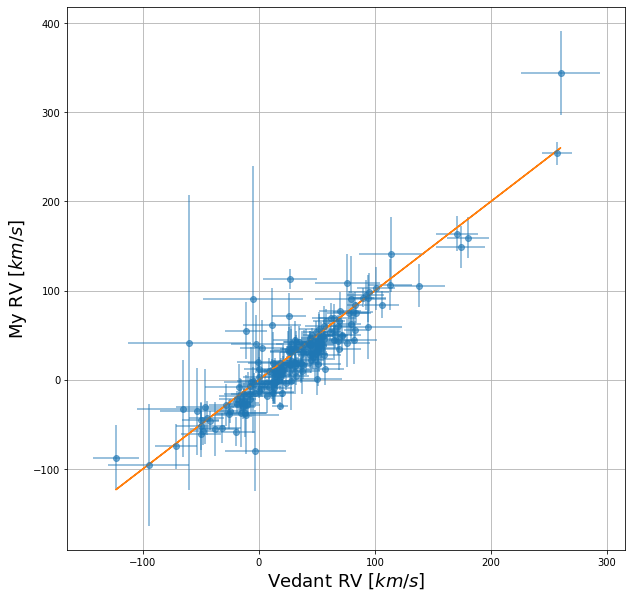

In [15]:
import scipy.stats as stats

def linear(x):
    return x

temp_catalog = catalog#[np.abs(stats.zscore(catalog['vr'])) < 1].copy()

plt.figure(figsize=(10,10))
plt.grid()

plt.errorbar(catalog['vr'][np.abs(catalog['corv_rv']) < 2500], catalog['corv_rv'][np.abs(catalog['corv_rv']) < 2500], 
             xerr = catalog['dvr'][np.abs(catalog['corv_rv']) < 2500], yerr = catalog['corv_erv'][np.abs(catalog['corv_rv']) < 2500], fmt='o', alpha = 0.6)
plt.plot(catalog['vr'][np.abs(catalog['corv_rv']) < 2500], linear(catalog['vr'][np.abs(catalog['corv_rv']) < 2500]))


ymin, ymax = plt.ylim()
plt.xlabel(r'Vedant RV $[km/s]$', fontsize=18)
plt.ylabel(r'My RV $[km/s]$', fontsize=18)
#plt.colorbar()

In [30]:
from astropy.io import ascii

falcon = Table.read('data/verification/falcon2010.fit')

In [31]:
print(falcon)

   _Glon       _Glat      _RAJ2000    _DEJ2000       Name     ...  Obs-V  e_Obs-V Simbad    _RA       _DE   
    deg         deg         deg         deg                   ...  km / s  km / s           deg       deg   
----------- ----------- ----------- ----------- ------------- ... ------- ------- ------ --------- ---------
 68.6811530 -75.8545186   0.7967083 -18.3660000 WD 0000-186   ...  24.531   0.073 Simbad   0.79671 -18.36600
 68.6811530 -75.8545186   0.7967083 -18.3660000 WD 0000-186   ...  24.343   1.236 Simbad   0.79671 -18.36600
107.1548732 -44.5646136   1.1805833  16.8713056 HS 0002+1635  ...  23.518   2.450 Simbad   1.18058  16.87131
 78.0385783 -74.9936026   1.8950000 -16.0921667 WD 0005-163   ...  15.006   0.140 Simbad   1.89500 -16.09217
 78.0385783 -74.9936026   1.8950000 -16.0921667 WD 0005-163   ...  14.907   3.445 Simbad   1.89500 -16.09217
103.0899741 -61.0846261   3.4132917   0.3230833 WD 0011+000   ...  22.823   0.978 Simbad   3.41329   0.32308
103.0899741 -61.084

In [36]:
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.table import Table, join_skycoord
from astropy import table

catalog['wd_pos'] = SkyCoord(catalog['ra'], catalog['dec'], unit='deg')
falcon['wd_pos'] = SkyCoord(falcon['_RA'], falcon['_DE'], unit='deg')

join_func = table.join_skycoord(5 * u.arcsecond)
falcon_xmatch = table.join(catalog, falcon, join_funcs={'wd_pos': join_skycoord(5 * u.arcsec)})

In [39]:
print(falcon_xmatch.keys())

['wd_pos_id', 'dist', 'solution_id', 'designation', 'source_id', 'random_index', 'ref_epoch', 'ra', 'ra_error', 'dec', 'dec_error', 'parallax', 'parallax_error', 'parallax_over_error', 'pmra', 'pmra_error', 'pmdec', 'pmdec_error', 'ra_dec_corr', 'ra_parallax_corr', 'ra_pmra_corr', 'ra_pmdec_corr', 'dec_parallax_corr', 'dec_pmra_corr', 'dec_pmdec_corr', 'parallax_pmra_corr', 'parallax_pmdec_corr', 'pmra_pmdec_corr', 'astrometric_n_obs_al', 'astrometric_n_obs_ac', 'astrometric_n_good_obs_al', 'astrometric_n_bad_obs_al', 'astrometric_gof_al', 'astrometric_chi2_al', 'astrometric_excess_noise', 'astrometric_excess_noise_sig', 'astrometric_params_solved', 'astrometric_primary_flag', 'astrometric_weight_al', 'astrometric_pseudo_colour', 'astrometric_pseudo_colour_error', 'mean_varpi_factor_al', 'astrometric_matched_observations', 'visibility_periods_used', 'astrometric_sigma5d_max', 'frame_rotator_object_type', 'matched_observations', 'duplicated_source', 'phot_g_n_obs', 'phot_g_mean_flux', '

In [40]:
for j in tqdm( range(len(falcon_xmatch))):
    p,m,f = np.array(falcon_xmatch['col_p_m_f'][j].split('-')).astype(float)
    
    try:
        xid = SDSS.query_specobj(plate = p, mjd = m, fiberID = f)
    except ValueError:
        print('unknown error')
        
    if xid == None:
        print('object not found in SDSS... skipping...')
        continue
    try:
        sp = SDSS.get_spectra(matches=xid)
    except:
        print('http error')
        continue
    for i in range(len(sp[0:1])):
        wl = np.array(10**sp[i][1].data['loglam'])
        fl = np.array(sp[i][1].data['flux'])
        ivar = np.array(sp[i][1].data['ivar'])
        
        corvmodel = corv.models.make_koester_model(names = ['a','b','g','d'])
        param_res, rv_res, rv_init = corv.fit.fit_corv(wl, fl, ivar, corvmodel, teff = catalog['teff'][j])
        print(catalog['vr'][j])
        
    falcon_xmatch['corv_rv'][j] = (rv_res.params['RV'].value)
    falcon_xmatch['corv_erv'][j] = (rv_res.params['RV'].stderr)

  0%|                                                                                    | 0/97 [00:00<?, ?it/s]/home/arseneausm/anaconda3/lib/python3.8/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),
/home/arseneausm/anaconda3/lib/python3.8/site-packages/astropy/table/table.py:3474: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


starting...


  1%|▊                                                                        | 1/97 [03:13<5:09:39, 193.54s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [28.05976511]
final params:
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 50000
    # data points      = 629
    # variables        = 1
    chi-square         = 938.71924
    reduced chi-square = 1.49477586
    Akaike info crit   = 253.842276
    Bayesian info crit = 258.286408
[[Variables]]
    teff:  30901 (fixed)
    logg:  8.182706 (fixed)
    RV:    74.5482818 +/- 8.42369858 (11.30%) (init = 103.8004)
    res:   1 (fixed)
rv init: 103.80040450963476
28.0
starting...


  2%|█▌                                                                       | 2/97 [06:28<5:07:36, 194.28s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [23.37162501]
final params:
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 50000
    # data points      = 629
    # variables        = 1
    chi-square         = 18465.502
    reduced chi-square = 29.4036655
    Akaike info crit   = 2127.72327
    Bayesian info crit = 2132.16740
[[Variables]]
    teff:  28778 (fixed)
    logg:  9.489945 (fixed)
    RV:    33.4756485 +/- 3.75993638 (11.23%) (init = 28.75835)
    res:   1 (fixed)
rv init: 28.75835463628057
83.0
starting...


  3%|██▎                                                                      | 3/97 [09:38<5:01:31, 192.46s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [27.45695503]
final params:
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 50000
    # data points      = 629
    # variables        = 1
    chi-square         = 12588.363
    reduced chi-square = 20.0451645
    Akaike info crit   = 1886.73363
    Bayesian info crit = 1891.17776
[[Variables]]
    teff:  15324 (fixed)
    logg:  9.489945 (fixed)
    RV:    20.7280602 +/- 2.44574297 (11.80%) (init = 28.75835)
    res:   1 (fixed)
rv init: 28.75835463628057
-20.0
starting...


  4%|███                                                                      | 4/97 [13:14<5:12:51, 201.84s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [24.09699854]
final params:
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 50000
    # data points      = 629
    # variables        = 1
    chi-square         = 4091.06
    reduced chi-square = 6.51442684
    Akaike info crit   = 1179.75730
    Bayesian info crit = 1184.20143
[[Variables]]
    teff:  23616 (fixed)
    logg:  9.48999 (fixed)
    RV:    30.6919229 +/- 5.30659900 (17.29%) (init = 34.0695)
    res:   1 (fixed)
rv init: 34.06949510734591
12.0
starting...


  5%|███▊                                                                     | 5/97 [16:30<5:06:18, 199.77s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [38.86864497]
final params:
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 50000
    # data points      = 629
    # variables        = 1
    chi-square         = 14143.168
    reduced chi-square = 22.5209681
    Akaike info crit   = 1959.98624
    Bayesian info crit = 1964.43037
[[Variables]]
    teff:  39999 (fixed)
    logg:  7.932726 (fixed)
    RV:   -4.56682969 +/- 4.12288217 (90.28%) (init = 31.31716)
    res:   1 (fixed)
rv init: 31.317156514634576
0.0
starting...


  6%|████▌                                                                    | 6/97 [19:59<5:07:18, 202.62s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [21.37301881]
final params:
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 50000
    # data points      = 629
    # variables        = 1
    chi-square         = 1955.0741
    reduced chi-square = 3.11317531
    Akaike info crit   = 715.318781
    Bayesian info crit = 719.762912
[[Variables]]
    teff:  16041 (fixed)
    logg:  8.825728 (fixed)
    RV:    24.4493516 +/- 4.47249668 (18.29%) (init = 28.09561)
    res:   1 (fixed)
rv init: 28.095613677271785
82.0
starting...


  7%|█████▏                                                                  | 7/97 [56:09<21:08:57, 845.97s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [26.68138781]
final params:
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 50000
    # data points      = 629
    # variables        = 1
    chi-square         = 30722.473
    reduced chi-square = 48.9211348
    Akaike info crit   = 2447.94098
    Bayesian info crit = 2452.38512
[[Variables]]
    teff:  30881 (fixed)
    logg:  8.825728 (fixed)
    RV:    36.8891572 +/- 4.18874803 (11.35%) (init = 28.09561)
    res:   1 (fixed)
rv init: 28.095613677271785
-25.0
starting...


  8%|█████▊                                                                | 8/97 [1:01:23<16:43:24, 676.46s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [21.59451679]
final params:
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 50000
    # data points      = 629
    # variables        = 1
    chi-square         = 12524.502
    reduced chi-square = 19.9434744
    Akaike info crit   = 1883.53456
    Bayesian info crit = 1887.97869
[[Variables]]
    teff:  20904 (fixed)
    logg:  7.873329 (fixed)
    RV:   -37.6144211 +/- 1.17343162 (3.12%) (init = -37.52973)
    res:   1 (fixed)
rv init: -37.5297271893224
5.0
starting...


  9%|██████▍                                                               | 9/97 [1:06:19<13:37:58, 557.71s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [21.5708805]
final params:
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 50000
    # data points      = 629
    # variables        = 1
    chi-square         = 10913.107
    reduced chi-square = 17.3775596
    Akaike info crit   = 1796.90723
    Bayesian info crit = 1801.35136
[[Variables]]
    teff:  20362 (fixed)
    logg:  7.873329 (fixed)
    RV:   -37.6316548 +/- 1.32590149 (3.52%) (init = -37.52973)
    res:   1 (fixed)
rv init: -37.5297271893224
46.0
starting...


 10%|███████                                                              | 10/97 [1:10:51<11:20:45, 469.49s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [30.7688508]
final params:
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 50000
    # data points      = 629
    # variables        = 1
    chi-square         = 17627.291
    reduced chi-square = 28.0689347
    Akaike info crit   = 2098.50251
    Bayesian info crit = 2102.94664
[[Variables]]
    teff:  34334 (fixed)
    logg:  8.80878 (fixed)
    RV:    127.015371 +/- 3.57838871 (2.82%) (init = 146.0097)
    res:   1 (fixed)
rv init: 146.0096871672038
3.0
starting...


 11%|███████▉                                                              | 11/97 [1:15:20<9:44:52, 408.05s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [23.17012864]
final params:
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 50000
    # data points      = 629
    # variables        = 1
    chi-square         = 903.0475
    reduced chi-square = 1.43797370
    Akaike info crit   = 229.474001
    Bayesian info crit = 233.918133
[[Variables]]
    teff:  16890 (fixed)
    logg:  8.922923 (fixed)
    RV:    47.2401460 +/- 5.17016035 (10.94%) (init = 48.59436)
    res:   1 (fixed)
rv init: 48.59436108248351
72.0
starting...


 12%|████████▋                                                             | 12/97 [1:19:51<8:38:51, 366.26s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [23.7643523]
final params:
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 50000
    # data points      = 629
    # variables        = 1
    chi-square         = 1674.8492
    reduced chi-square = 2.66695739
    Akaike info crit   = 618.009376
    Bayesian info crit = 622.453507
[[Variables]]
    teff:  20596 (fixed)
    logg:  8.922923 (fixed)
    RV:    42.8417035 +/- 5.87583349 (13.72%) (init = 48.59436)
    res:   1 (fixed)
rv init: 48.59436108248351
14.0
starting...


 13%|█████████▍                                                            | 13/97 [1:24:47<8:03:13, 345.16s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [37.25997246]
final params:
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 50000
    # data points      = 629
    # variables        = 1
    chi-square         = 89207.016
    reduced chi-square = 142.049388
    Akaike info crit   = 3118.43315
    Bayesian info crit = 3122.87728
[[Variables]]
    teff:  6618 (fixed)
    logg:  9.489995 (fixed)
    RV:    19.0954681 +/- 32.5425489 (170.42%) (init = 48.05869)
    res:   1 (fixed)
rv init: 48.05868720579428
-123.0
starting...


 14%|██████████                                                            | 14/97 [1:29:08<7:22:05, 319.59s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [20.5712327]
final params:
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 50000
    # data points      = 629
    # variables        = 1
    chi-square         = 5631.5454
    reduced chi-square = 8.96742900
    Akaike info crit   = 1380.77298
    Bayesian info crit = 1385.21711
[[Variables]]
    teff:  19441 (fixed)
    logg:  9.489995 (fixed)
    RV:    43.9967761 +/- 5.01014721 (11.39%) (init = 48.05869)
    res:   1 (fixed)
rv init: 48.05868720579428
-10.0
starting...


 15%|██████████▊                                                           | 15/97 [1:33:25<6:51:16, 300.93s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [21.94696631]
final params:
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 50000
    # data points      = 629
    # variables        = 1
    chi-square         = 5316.464
    reduced chi-square = 8.46570679
    Akaike info crit   = 1344.55799
    Bayesian info crit = 1349.00212
[[Variables]]
    teff:  20272 (fixed)
    logg:  9.489995 (fixed)
    RV:    43.7032884 +/- 4.99726203 (11.43%) (init = 48.05869)
    res:   1 (fixed)
rv init: 48.05868720579428
29.0
starting...


 16%|███████████▌                                                          | 16/97 [1:37:50<6:31:26, 289.95s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [40.83102161]
final params:
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 50000
    # data points      = 629
    # variables        = 1
    chi-square         = 78078.266
    reduced chi-square = 124.328448
    Akaike info crit   = 3034.62019
    Bayesian info crit = 3039.06432
[[Variables]]
    teff:  7779 (fixed)
    logg:  8.848911 (fixed)
    RV:    40.4797941 +/- 2.65425755 (6.56%) (init = 56.55258)
    res:   1 (fixed)
rv init: 56.55257846690991
-8.0
starting...


 18%|████████████▎                                                         | 17/97 [1:42:09<6:14:24, 280.81s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [23.88929763]
final params:
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 50000
    # data points      = 629
    # variables        = 1
    chi-square         = 23073.5
    reduced chi-square = 36.7412420
    Akaike info crit   = 2267.85223
    Bayesian info crit = 2272.29636
[[Variables]]
    teff:  28733 (fixed)
    logg:  8.848911 (fixed)
    RV:    50.9940331 +/- 2.86399015 (5.62%) (init = 56.55258)
    res:   1 (fixed)
rv init: 56.55257846690991
-5.0
starting...


 19%|████████████▉                                                         | 18/97 [1:46:25<5:59:45, 273.24s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [39.95667948]
final params:
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 50000
    # data points      = 629
    # variables        = 1
    chi-square         = 42328.168
    reduced chi-square = 67.4015414
    Akaike info crit   = 2649.50930
    Bayesian info crit = 2653.95344
[[Variables]]
    teff:  39999 (fixed)
    logg:  9.243865 (fixed)
    RV:   -7.52614696 +/- 3.91693736 (52.04%) (init = 8.437638)
    res:   1 (fixed)
rv init: 8.437637834495506
-2.0
starting...


 20%|█████████████▋                                                        | 19/97 [1:50:45<5:49:55, 269.17s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [23.69252505]
final params:
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 50000
    # data points      = 629
    # variables        = 1
    chi-square         = 2559.7698
    reduced chi-square = 4.07606652
    Akaike info crit   = 884.827506
    Bayesian info crit = 889.271637
[[Variables]]
    teff:  14042 (fixed)
    logg:  9.243865 (fixed)
    RV:    12.8060789 +/- 3.99923145 (31.23%) (init = 8.437638)
    res:   1 (fixed)
rv init: 8.437637834495506
32.0
starting...


 21%|██████████████▍                                                       | 20/97 [1:55:03<5:41:15, 265.91s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [25.71777846]
final params:
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 50000
    # data points      = 629
    # variables        = 1
    chi-square         = 21787.156
    reduced chi-square = 34.6929240
    Akaike info crit   = 2231.77019
    Bayesian info crit = 2236.21432
[[Variables]]
    teff:  34208 (fixed)
    logg:  9.489999 (fixed)
    RV:    51.5893188 +/- 4.17192478 (8.09%) (init = 43.56399)
    res:   1 (fixed)
rv init: 43.56398873833545
25.0
starting...


 22%|███████████████▏                                                      | 21/97 [1:59:18<5:32:39, 262.63s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [21.42053288]
final params:
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 50000
    # data points      = 629
    # variables        = 1
    chi-square         = 2523.8877
    reduced chi-square = 4.01892945
    Akaike info crit   = 875.947992
    Bayesian info crit = 880.392124
[[Variables]]
    teff:  23573 (fixed)
    logg:  9.489999 (fixed)
    RV:    38.4317380 +/- 5.33848369 (13.89%) (init = 43.56399)
    res:   1 (fixed)
rv init: 43.56398873833545
32.0
starting...


 23%|███████████████▉                                                      | 22/97 [2:03:34<5:25:52, 260.71s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [23.21365447]
final params:
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 50000
    # data points      = 629
    # variables        = 1
    chi-square         = 5377.5713
    reduced chi-square = 8.56301161
    Akaike info crit   = 1351.74648
    Bayesian info crit = 1356.19061
[[Variables]]
    teff:  24454 (fixed)
    logg:  8.667584 (fixed)
    RV:    50.2225252 +/- 4.80941011 (9.58%) (init = 56.30615)
    res:   1 (fixed)
rv init: 56.30614899272348
66.0
starting...


 24%|████████████████▌                                                     | 23/97 [2:07:50<5:19:54, 259.38s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [22.18134763]
final params:
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 50000
    # data points      = 629
    # variables        = 1
    chi-square         = 12283.088
    reduced chi-square = 19.5590572
    Akaike info crit   = 1871.29200
    Bayesian info crit = 1875.73613
[[Variables]]
    teff:  28834 (fixed)
    logg:  8.667584 (fixed)
    RV:    50.5812944 +/- 4.50782644 (8.91%) (init = 56.30615)
    res:   1 (fixed)
rv init: 56.30614899272348
27.0
starting...


 25%|█████████████████▎                                                    | 24/97 [2:12:07<5:14:27, 258.46s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [42.51271281]
final params:
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 50000
    # data points      = 629
    # variables        = 1
    chi-square         = 136972.11
    reduced chi-square = 218.108454
    Akaike info crit   = 3388.15945
    Bayesian info crit = 3392.60358
[[Variables]]
    teff:  39999 (fixed)
    logg:  8.585886 (fixed)
    RV:   -8.84174648 +/- 2.07138553 (23.43%) (init = 3.084499)
    res:   1 (fixed)
rv init: 3.0844985461896846
11.0
starting...


 26%|██████████████████                                                    | 25/97 [2:16:21<5:08:27, 257.05s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [39.33301664]
final params:
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 50000
    # data points      = 629
    # variables        = 1
    chi-square         = 136972.53
    reduced chi-square = 218.109126
    Akaike info crit   = 3388.16138
    Bayesian info crit = 3392.60552
[[Variables]]
    teff:  39999 (fixed)
    logg:  8.585886 (fixed)
    RV:   -8.85696237 +/- 2.02649711 (22.88%) (init = 3.084499)
    res:   1 (fixed)
rv init: 3.0844985461896846
27.0
starting...


 27%|██████████████████▊                                                   | 26/97 [2:20:40<5:05:01, 257.77s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [24.15289242]
final params:
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 50000
    # data points      = 629
    # variables        = 1
    chi-square         = 985.0289
    reduced chi-square = 1.56851731
    Akaike info crit   = 284.131467
    Bayesian info crit = 288.575598
[[Variables]]
    teff:  17114 (fixed)
    logg:  8.142292 (fixed)
    RV:    37.2198386 +/- 9.06308748 (24.35%) (init = 31.64594)
    res:   1 (fixed)
rv init: 31.64594357758792
57.0
starting...


 28%|███████████████████▍                                                  | 27/97 [2:24:55<4:59:55, 257.08s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [23.93774387]
final params:
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 50000
    # data points      = 629
    # variables        = 1
    chi-square         = 8284.589
    reduced chi-square = 13.1920205
    Akaike info crit   = 1623.57524
    Bayesian info crit = 1628.01937
[[Variables]]
    teff:  23246 (fixed)
    logg:  8.142292 (fixed)
    RV:    32.0838329 +/- 3.41561705 (10.65%) (init = 31.64594)
    res:   1 (fixed)
rv init: 31.64594357758792
56.0
starting...


 29%|████████████████████▏                                                 | 28/97 [2:29:04<4:52:50, 254.64s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [25.38475578]
final params:
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 50000
    # data points      = 629
    # variables        = 1
    chi-square         = 1192.1846
    reduced chi-square = 1.89838307
    Akaike info crit   = 404.189783
    Bayesian info crit = 408.633914
[[Variables]]
    teff:  20596 (fixed)
    logg:  9.004205 (fixed)
    RV:    42.7046567 +/- 6.93587468 (16.24%) (init = 55.03808)
    res:   1 (fixed)
rv init: 55.0380766560527
46.0
starting...


 30%|████████████████████▉                                                 | 29/97 [2:33:14<4:46:44, 253.00s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [22.33169855]
final params:
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 50000
    # data points      = 629
    # variables        = 1
    chi-square         = 21505.812
    reduced chi-square = 34.2449244
    Akaike info crit   = 2223.59483
    Bayesian info crit = 2228.03896
[[Variables]]
    teff:  39999 (fixed)
    logg:  9.004205 (fixed)
    RV:    51.9094323 +/- 4.99481413 (9.62%) (init = 55.03808)
    res:   1 (fixed)
rv init: 55.0380766560527
-11.0
starting...


 31%|█████████████████████▋                                                | 30/97 [2:37:33<4:44:46, 255.03s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [23.14658192]
final params:
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 50000
    # data points      = 629
    # variables        = 1
    chi-square         = 2039.7286
    reduced chi-square = 3.24797554
    Akaike info crit   = 741.981264
    Bayesian info crit = 746.425395
[[Variables]]
    teff:  18601 (fixed)
    logg:  8.40272 (fixed)
    RV:    26.1962726 +/- 5.26763832 (20.11%) (init = 28.57651)
    res:   1 (fixed)
rv init: 28.576509777295595
35.0
starting...


 32%|██████████████████████▎                                               | 31/97 [2:41:47<4:40:09, 254.69s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [22.86675019]
final params:
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 50000
    # data points      = 629
    # variables        = 1
    chi-square         = 9924.182
    reduced chi-square = 15.8028370
    Akaike info crit   = 1737.15839
    Bayesian info crit = 1741.60252
[[Variables]]
    teff:  24437 (fixed)
    logg:  8.40272 (fixed)
    RV:    30.7575582 +/- 2.63878463 (8.58%) (init = 28.57651)
    res:   1 (fixed)
rv init: 28.576509777295595
54.0
starting...


 33%|███████████████████████                                               | 32/97 [2:46:08<4:37:47, 256.42s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [23.97966107]
final params:
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 50000
    # data points      = 629
    # variables        = 1
    chi-square         = 2529.3374
    reduced chi-square = 4.02760733
    Akaike info crit   = 877.304697
    Bayesian info crit = 881.748828
[[Variables]]
    teff:  19048 (fixed)
    logg:  8.141378 (fixed)
    RV:    36.3304374 +/- 5.50108690 (15.14%) (init = 35.76215)
    res:   1 (fixed)
rv init: 35.76214965099458
32.0
starting...


 34%|███████████████████████▊                                              | 33/97 [2:50:30<4:35:14, 258.05s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [26.86965189]
final params:
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 50000
    # data points      = 629
    # variables        = 1
    chi-square         = 691.8267
    reduced chi-square = 1.10163491
    Akaike info crit   = 61.8834825
    Bayesian info crit = 66.3276137
[[Variables]]
    teff:  16384 (fixed)
    logg:  8.141378 (fixed)
    RV:    47.0499311 +/- 5.07167917 (10.78%) (init = 35.76215)
    res:   1 (fixed)
rv init: 35.76214965099458
20.0
starting...


 35%|████████████████████████▌                                             | 34/97 [2:54:51<5:24:00, 308.57s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [36.20385577]
final params:
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 50000
    # data points      = 629
    # variables        = 1
    chi-square         = 35433.656
    reduced chi-square = 56.4230195
    Akaike info crit   = 2537.67898
    Bayesian info crit = 2542.12311
[[Variables]]
    teff:  30923 (fixed)
    logg:  9.042453 (fixed)
    RV:    61.7294853 +/- 3.00192981 (4.86%) (init = 83.01141)
    res:   1 (fixed)
rv init: 83.01140502668655
94.0


ConnectionError: ('Connection aborted.', ConnectionResetError(104, 'Connection reset by peer'))

Text(0, 0.5, 'My RV $[km/s]$')

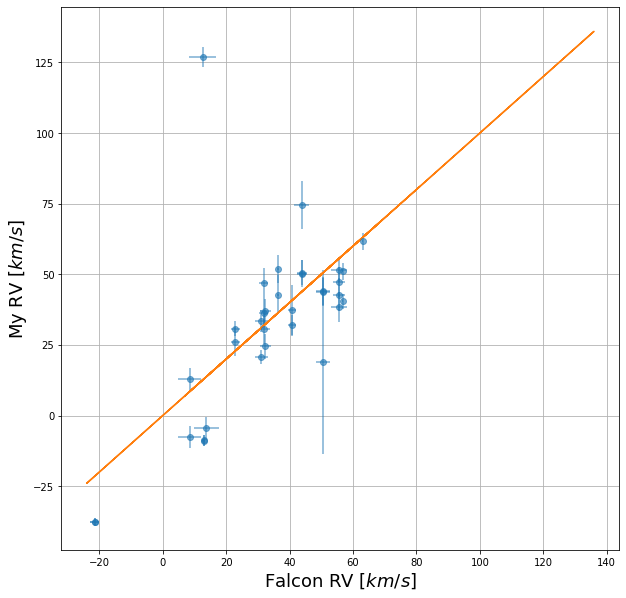

In [42]:
import scipy.stats as stats

def linear(x):
    return x

temp_catalog = catalog#[np.abs(stats.zscore(catalog['vr'])) < 1].copy()

plt.figure(figsize=(10,10))
plt.grid()

plt.errorbar(falcon_xmatch['Adp-V'][np.abs(falcon_xmatch['corv_rv']) < 2500], falcon_xmatch['corv_rv'][np.abs(falcon_xmatch['corv_rv']) < 2500], 
             xerr = falcon_xmatch['e_Adp-V'][np.abs(falcon_xmatch['corv_rv']) < 2500], yerr = falcon_xmatch['corv_erv'][np.abs(falcon_xmatch['corv_rv']) < 2500], fmt='o', alpha = 0.6)
plt.plot(falcon_xmatch['vr'][np.abs(falcon_xmatch['corv_rv']) < 2500], linear(falcon_xmatch['vr'][np.abs(falcon_xmatch['corv_rv']) < 2500]))


ymin, ymax = plt.ylim()
plt.xlabel(r'Falcon RV $[km/s]$', fontsize=18)
plt.ylabel(r'My RV $[km/s]$', fontsize=18)
#plt.colorbar()

## Sirius Validation
Sirius B
* Right ascension: 06h 45m 09.0s
* Declination: −16° 43′ 06″RightRight

In [120]:
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.table import Table

siriusa = SkyCoord('06 45 08.917 −16 42 58.02',  unit=(u.hourangle, u.deg), frame='icrs') 
siriusb = SkyCoord('06 45 09 -16 43 06',  unit=(u.hourangle, u.deg), frame='icrs')

sirius = Table([['sirius_a', 'sirius_b'], [siriusa.ra.deg, siriusb.ra.deg], [siriusa.dec.deg, siriusb.dec.deg],[siriusa, siriusb]], names=('star', 'ra', 'dec', 'skycoord'))
print(sirius)

radius = u.Quantity(30.0, u.arcmin)

  star           ra                 dec                        skycoord               
                                                               deg,deg                
-------- ------------------ ------------------- --------------------------------------
sirius_a 101.28715416666665 -16.716116666666665 101.28715416666665,-16.716116666666665
sirius_b           101.2875  -16.71833333333333            101.2875,-16.71833333333333


In [124]:
print(siriusa.ra, siriusa.dec)
print(siriusb.ra, siriusb.dec)

result = Gaia.query_object(siriusa, radius = radius)
print(len(result))

101d17m13.755s -16d42m58.02s
101d17m15s -16d43m06s
50


In [125]:
result['skycoord'] = SkyCoord(result['ra'], result['dec'], unit=(u.deg, u.deg))
#catalog = join(result, sirius, keys='ra', join_type='inner')

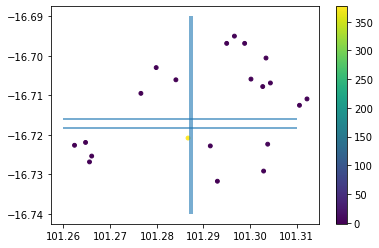

In [140]:
plt.scatter(result['ra'], result['dec'], s=15, c=result['parallax'])
plt.vlines(sirius['ra'], ymin=-16.74, ymax=-16.69, alpha=0.8) 
plt.hlines(sirius['dec'], xmin=101.26, xmax=101.31, alpha=0.8) 
plt.colorbar()

In [46]:
from astroquery.sdss import SDSS
from astroquery.gaia import Gaia

j1 = Gaia.cone_search_async(siriusa, radius)
#j2 = Gaia.cone_search_async(siriusb, radius)

INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]


In [48]:
sirius_a_gaia = j1.get_results()[0]
#sirius_b_gaia = j2.get_results()[0]

In [56]:
#print(sirius_a_gaia['solution_id'] == sirius_b_gaia['solution_id'])
print(sirius_a_gaia['phot_g_mean_mag'])

8.474459
